# Imports

In [115]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm import tqdm
from typing import Optional, List, Union # type tips

# Load Data

In [116]:
# df is the non-normalized passive data with features and target 
# df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_passive_fe.csv')
df = pd.read_csv('../../../3_3_2_processed_data/modeling/all_data/all_features.csv')

# mlm_gap_df is the results of the MLM on the gap data
mlm_gap_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_gap_results_df.csv')
mlm_affect_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_affect_results_df.csv')

# Functions

In [117]:
def create_train_test_split(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Creates train/test splits for time series data on a per-participant basis.
    
    For each participant (PID):
    1. Finds their last day of data collection based on unlock duration data
    2. Removes any data after their last valid day
    3. Creates an 80/20 chronological train/test split
    
    Args:
        data: DataFrame containing participant data with columns:
            - PID: Participant ID
            - day: Day number of study
            - passive_sk_device_total_unlock_duration: Unlock duration data
            
    Returns:
        tuple containing:
            - train_data: DataFrame with first 80% of each participant's data
            - test_data: DataFrame with last 20% of each participant's data
    """
    # Get last day of data collection for each PID based on unlock duration data
    last_days = data.groupby('PID').agg({
        'day': lambda x: x[data['passive_sk_device_total_unlock_duration'].notna()].max()
    }).reset_index()

    # Remove any data after each PID's last day
    tt_filtered = pd.merge(
        data,
        last_days,
        on='PID',
        suffixes=('', '_last')
    )
    tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]
    
    # Create train/test splits for each PID
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for pid in tt_filtered['PID'].unique():
        pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
        
        # Sort by day to ensure chronological split
        pid_data = pid_data.sort_values('day')
        
        # Calculate split point at 80%
        split_idx = int(len(pid_data) * 0.8)
        
        # Split the data
        train_pid = pid_data.iloc[:split_idx]
        test_pid = pid_data.iloc[split_idx:]
        
        # Append to main dataframes
        train_data = pd.concat([train_data, train_pid])
        test_data = pd.concat([test_data, test_pid])
        
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [118]:
def expanding_window_cv_nested(df: pd.DataFrame, validation_days: int = 15) -> list[tuple[np.ndarray, np.ndarray]]:
    """
    Performs expanding window cross-validation accounting for nested observations within subjects.
    Creates 5 splits, each moving forward by 3 days and using 3 days for validation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Training data containing 'PID' and 'day' columns
    validation_days : int
        Number of days to use for validation windows
        
    Returns:
    --------
    list of tuples
        Each tuple contains (train_idx, val_idx) for one fold, 
        where indices from all subjects are combined
    """
    # Dictionary to store splits by window position
    window_splits = {}  # {window_position: [(train_idx, val_idx), ...]}
    
    # Process each subject separately
    for pid in df['PID'].unique():
        # Get data for this subject
        subject_data = df[df['PID'] == pid].copy()
        
        # Get sorted unique days for this subject
        subject_days = sorted(subject_data['day'].unique())
        n_days = len(subject_days)
        
        # Skip subjects with too few observations
        if n_days < 25:  # means min of 10 days in initial training
            continue
            
        # Determine window days for this subject
        window_start_idx = max(0, n_days - validation_days)
        window_days = subject_days[window_start_idx:]
        
        # Create 5 splits, moving forward by 3 days each time
        for window_pos in range(0, 5):  # 5 splits
            val_start_idx = window_start_idx + (window_pos * 3)  # Move forward by 3 days each time
            
            # Skip if we don't have enough days left
            if val_start_idx + 3 > len(subject_days):
                continue
                
            # Get 3 validation days
            val_days = subject_days[val_start_idx:val_start_idx + 3]
            
            # Get training days (all days up to validation period)
            train_days = subject_days[:val_start_idx]
            
            # Get indices for this split
            train_mask = (df['PID'] == pid) & (df['day'].isin(train_days))
            val_mask = (df['PID'] == pid) & (df['day'].isin(val_days))
            
            # Convert to indices
            train_idx = np.where(train_mask)[0]
            val_idx = np.where(val_mask)[0]
            
            # Only add split if we have both training and validation data
            if len(train_idx) > 0 and len(val_idx) > 0:
                # Add to window_splits dictionary
                if window_pos not in window_splits:
                    window_splits[window_pos] = []
                window_splits[window_pos].append((train_idx, val_idx))
    
    # Combine splits for each window position
    combined_splits = []
    for window_pos in sorted(window_splits.keys()):
        # Combine all train indices and all val indices for this window position
        all_train_idx = np.concatenate([split[0] for split in window_splits[window_pos]])
        all_val_idx = np.concatenate([split[1] for split in window_splits[window_pos]])
        combined_splits.append((all_train_idx, all_val_idx))
    
    return combined_splits

# Data Preprocessing

## Clean

In [119]:
# remove t_current
df = df.drop(columns=['t_current'])

# remove subject with wonky data
df = df[df['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']

## Data Subsets

### ID Features

In [120]:
# ID cols
id_cols = [
    'PID',
    'trial_date',
    'day',
    'cohort',
    'weekend',
    'day_of_week_0',
    'day_of_week_1',
    'day_of_week_2',
    'day_of_week_3',
    'day_of_week_4',
    'day_of_week_5',
    'day_of_week_6',
    ]

### Passive Features

In [121]:
# Passive features
passive_cols = [col for col in df.columns if 'passive' in col]

# Additional cols
additional_passive_cols = [
    'task_duration',
    'task_start_time',
    'task_end_time',
    'survey_complete',
    'tasks_complete',
    'watch_wearing'
]

# Create df_passive
passive_cols = passive_cols + additional_passive_cols

### Affect Features


In [168]:
# Affect features
affect_cols = [col for col in df.columns if 'affect_' in col]
affect_pm_cols = [col for col in df.columns if 'affect_' in col and not col.endswith('_am')]

### Self Report Features

In [122]:
# create list of self report features
sr_cols = [col for col in df.columns if 'sr_' in col]

# remove affect self report features
sr_cols = [col for col in sr_cols if 'affect' not in col]

# remove social support features
sr_cols = [col for col in sr_cols if 'ss_' not in col]

# remove goal related features
sr_cols = [col for col in sr_cols if '_goal' not in col]

# List of self report features directly related to gap
gap_related_sr = [
    'sr_DAILY_past24_procrastination',
    'sr_DAILY_past24_productivity',
    'sr_DAILY_past24_punctuality',
    'sr_DAILY_past24_satisfaction',
    'sr_DAILY_past24_values',
    'sr_DAILY_past24_gapCause_internal',
    'sr_DAILY_past24_gapCause_external',
    'sr_DAILY_past24_gap',
    'sr_DAILY_past24_ideal',
    'sr_DAILY_past24_change',
    'sr_gap_heuristic',
    'sr_gap_heuristic_intercept',
    'sr_gap_heuristic_slope',
    'sr_DAILY_past48to24_gap',
    'sr_DAILY_past48to24_gapCause_internal',
    'sr_DAILY_past48to24_gapCause_external'
]

# remove self report that seem directly related to gap
sr_cols = [col for col in sr_cols if not any(gap_term in col for gap_term in gap_related_sr)]

In [237]:
sr_cols

['sr_DAILY_next24_drinks',
 'sr_DAILY_next24_exercise',
 'sr_DAILY_next24_leisureNonSolo',
 'sr_DAILY_next24_leisureSolo',
 'sr_DAILY_next24_nonoccupation',
 'sr_DAILY_next24_occupation',
 'sr_DAILY_next24_sleep',
 'sr_DAILY_next24_socialMedia',
 'sr_DAILY_past24_diet',
 'sr_DAILY_past24_drinks',
 'sr_DAILY_past24_exercise',
 'sr_DAILY_past24_fatigue',
 'sr_DAILY_past24_illness',
 'sr_DAILY_past24_leisureNonSolo',
 'sr_DAILY_past24_leisureNonSoloMental',
 'sr_DAILY_past24_leisureNonSoloPhysical',
 'sr_DAILY_past24_leisureSolo',
 'sr_DAILY_past24_leisureSoloMental',
 'sr_DAILY_past24_leisureSoloPhysical',
 'sr_DAILY_past24_mentalEffort',
 'sr_DAILY_past24_nonoccupation',
 'sr_DAILY_past24_occupation',
 'sr_DAILY_past24_physicalEffort',
 'sr_DAILY_past24_sleep',
 'sr_DAILY_past24_socialMedia',
 'sr_DAILY_past24_unusualEvents',
 'sr_DAILY_gap_diet',
 'sr_DAILY_gap_sleep',
 'sr_DAILY_gap_occupation',
 'sr_DAILY_gap_nonoccupation',
 'sr_DAILY_gap_leisureSolo',
 'sr_DAILY_gap_leisureNonSolo'

In [131]:
# Get columns that don't contain task_, sr_, or passive_
other_cols = [col for col in df.columns if not any(x in col for x in ['task_', 'sr_', 'passive_', 'ss_', 'affect', 'fe_'])]
print("Columns not containing task_, sr_, passive_, ss_, affect, or fe_:")
print("\n".join(other_cols))

Columns not containing task_, sr_, passive_, ss_, affect, or fe_:
PID
day
survey_complete
tasks_complete
watch_wearing
weekend
day_of_week_0
day_of_week_1
day_of_week_2
day_of_week_3
day_of_week_4
day_of_week_5
day_of_week_6
trial_date
cohort
css
grades_avg


### Task Data

In [231]:
task_cols = [col for col in df.columns if 'task_' in col]

# Remove columns containing '_model_' as these do not change by day
task_cols = [col for col in task_cols if '_model_' not in col]

# Add 'css' column
task_cols.append('css')

# Add residual columns from df_good

In [236]:
df_good = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv', low_memory=False)
residual_cols = df_good.columns[df_good.columns.str.contains('residual') & ~df_good.columns.str.endswith('_norm')]

# remove sr_gap_heuristic_residual
residual_cols = [col for col in residual_cols if col != 'sr_gap_heuristic_residual']

# Add residual columns to task_cols
task_cols.extend(residual_cols)

## Feature Dataframes

In [85]:
# Create df_passive
df_passive = df[id_cols + passive_cols]

# Create df_sr
df_sr = df[id_cols + sr_cols]

# Create df_task
df_task = df[id_cols + task_cols]

## Targets

### Well-being Weighted Target
Based on `Gap_Weighting.ipynb`, using the MLM model with correlation of .484 with `sr_affect_net_avg`

| measure                  | weights   |
|--------------------------|----------:|
| values_adherence         | 0.530248  |
| overall_goal_completion  | 0.249118  |
| goal1_completion         | 0.146432  |
| goal2_completion         | 0.074202  |

In [137]:
# load undetrended data
df_undetrended = pd.read_csv('../../../3_3_2_processed_data/modeling/df_cleaned_no_outliers.csv')

In [138]:
# Filter df_undetrended to match days in df
df_undetrended = df_undetrended[df_undetrended['day'].isin(df['day'])]

# Print first and last day in df_undetrended
print("First day:", df_undetrended['day'].min())
print("Last day:", df_undetrended['day'].max())


First day: 5
Last day: 81


In [139]:
# Flip goal accomplishment to be report gap
df_undetrended['values_gap'] = 100 - df_undetrended['sr_DAILY_past24_values']
df_undetrended['goal1_gap'] = 100 - df_undetrended['sr_DAILY_goal1_report']
df_undetrended['goal2_gap'] = 100 - df_undetrended['sr_DAILY_goal2_report']

In [140]:
# Create weighted well-being gap target
def calculate_wbw_gap(row):
    # Define features and their weights
    feature_weights = {
        'values_gap': 0.530248,
        'sr_DAILY_past24_gap': 0.249118, 
        'goal1_gap': 0.146432,
        'goal2_gap': 0.074202
    }
    
    # Get available features (not NaN)
    available_features = {k:v for k,v in feature_weights.items() 
                        if not pd.isna(row[k])}
    
    # If no features available, return NaN
    if len(available_features) == 0:
        return np.nan
        
    # Renormalize weights of available features
    weight_sum = sum(available_features.values())
    normalized_weights = {k:v/weight_sum for k,v in available_features.items()}
    
    # Calculate weighted sum
    weighted_sum = sum(row[k] * v for k,v in normalized_weights.items())
    
    return weighted_sum

# Apply calculation to create new feature
df_undetrended['target_wbw_gap'] = df_undetrended.apply(calculate_wbw_gap, axis=1)

### Detrend Targets

In [129]:
from sklearn.linear_model import LinearRegression

# Function to detrend a single column
def detrend_column(group):
    """Detrend a single column while preserving its mean level.
    
    Args:
        group: pandas Series containing the data to detrend
        
    Returns:
        pandas Series with trend removed but original mean preserved
    """
    X = np.arange(len(group))
    X_poly = np.column_stack((X, X**2, X**3))
    
    # Remove NaN and infinite values
    mask = ~np.isnan(group) & ~np.isinf(group)
    X_clean = X_poly[mask]
    y_clean = group[mask]
    
    if len(y_clean) > 0:
        # Store original mean
        original_mean = y_clean.mean()
        
        # Fit trend
        model = LinearRegression().fit(X_clean, y_clean)
        trend = np.full(len(group), np.nan)
        trend[mask] = model.predict(X_clean)
        
        # Remove trend and add back original mean
        detrended = group - trend
        detrended[mask] = detrended[mask] + original_mean
        
        return detrended
    else:
        return group  # Return original if all values are NaN or infinite
    
# Create detrended version of target_wbw_gap
df_undetrended['target_wbw_gap_detrended'] = df_undetrended.groupby('PID')['target_wbw_gap'].transform(detrend_column)

### Join Targets

In [145]:
# Get all target columns from df_undetrended
target_cols = [col for col in df_undetrended.columns if col.startswith('target_')]

# Join target columns from df_undetrended to df
df = df.merge(
    df_undetrended[['PID', 'day'] + target_cols],
    on=['PID', 'day'],
    how='left'
)

# Change in gap over semester

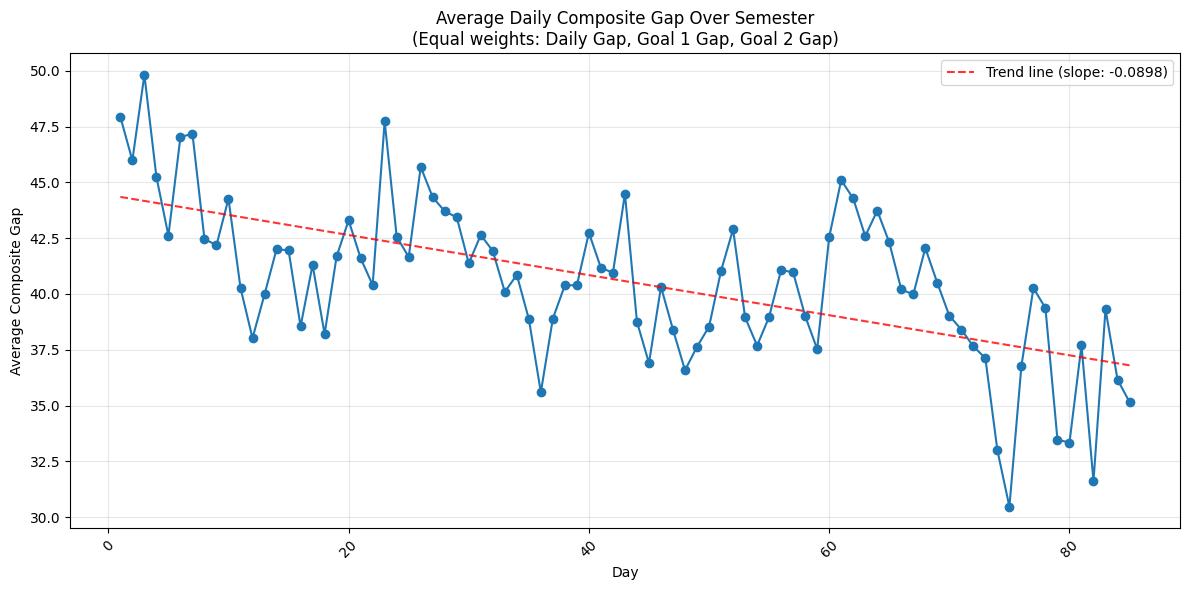

In [242]:
# Flip goal accomplishment to be goal gaps (100 - report)
df_good['goal1_gap'] = 100 - df_good['sr_DAILY_goal1_report']
df_good['goal2_gap'] = 100 - df_good['sr_DAILY_goal2_report']

# Create composite gap with equal weights (1/3 each)
df_good['composite_gap'] = (
    df_good['sr_DAILY_past24_gap'] * (1/3) + 
    df_good['goal1_gap'] * (1/3) + 
    df_good['goal2_gap'] * (1/3)
)

# Calculate mean composite gap per day across all participants
daily_mean_gap = df_good.groupby('day')['composite_gap'].mean()

# Fit linear trendline
x = np.array(daily_mean_gap.index)
y = daily_mean_gap.values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(daily_mean_gap.index, daily_mean_gap.values, '-o')
plt.plot(x, p(x), "r--", alpha=0.8, label=f'Trend line (slope: {z[0]:.4f})')

# Add labels and title
plt.xlabel('Day')
plt.ylabel('Average Composite Gap')
plt.title('Average Daily Composite Gap Over Semester\n(Equal weights: Daily Gap, Goal 1 Gap, Goal 2 Gap)')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

In [269]:
# Hard coded samples taken from distribution
samples = np.array([21, 17, 15, 20, 10, 24, 20, 20, 14, 22, 18, 15, 15, 14, 20, 14, 19, 17, 20, 17, 6, 16, 16, 15, 19, 17, 12, 13, 21, 19, 14, 20, 22, 11, 16, 12, 21, 20, 22, 22, 15, 12, 16, 23, 19, 17, 18, 17, 20, 19, 23, 13, 11, 14, 17, 19, 19, 19, 23, 15, 16, 17, 19, 20, 18, 20, 22, 22, 19, 20, 14, 23, 19, 21, 19, 12, 18, 20, 20, 14, 14, 17, 26, 16, 21, 23, 19, 20, 20, 16, 19, 18, 19, 6, 22, 20, 18, 21, 18, 18, 24, 19, 17, 22, 19, 18, 24, 18, 21, 18, 22, 19, 22, 15, 14, 22, 21, 13, 15, 23, 17, 18, 21, 25, 24, 21, 14, 16, 14, 20, 18, 20, 20, 15, 23, 15, 8, 17, 16, 16, 16, 22, 20, 22, 16, 14, 15, 19, 21, 24, 17, 17, 21, 19, 19, 20, 21, 17, 14, 21, 21, 18, 15, 13, 26, 17, 19, 17, 20, 21, 22, 18, 20, 13, 18, 16, 16, 20, 14, 13, 15, 21, 15, 24, 19, 14, 20, 21, 9, 8, 18, 21, 14, 19, 19, 13, 21, 16, 21, 21, 17, 21, 19, 13, 19, 21, 20, 21, 16, 21, 8, 17, 13, 25, 18, 15, 7, 10, 13, 5, 18, 14, 21, 19, 17, 19, 21, 11, 19, 20, 19, 15, 17, 19, 18, 23, 7, 16, 20, 19, 18, 17, 10, 19, 19, 20, 21, 19, 18, 13, 22, 23, 17, 17, 19, 15, 23, 13, 20, 22, 14, 16, 25, 14, 17, 10, 13, 20, 19, 12, 22, 16, 18, 19, 12, 20, 23, 14, 13, 23, 22, 13, 16, 19, 17, 17, 19, 23, 18, 21, 14, 17, 22, 18, 21, 15, 17, 21, 24, 20, 15, 16, 15, 14, 22, 15, 22, 14, 16, 19, 13, 16, 19, 21, 15, 20, 19, 23, 19, 22, 26, 19, 19, 21, 10, 20, 20, 22, 16, 25, 22, 16, 19, 19, 22, 12, 22, 21, 14, 17, 13, 17, 17, 12, 23, 23, 17, 18, 19, 17, 19, 17, 21, 13, 17, 22, 22, 23, 21, 23, 16, 20, 17, 22, 11, 18, 11, 13, 18, 7, 18, 22, 24, 14, 21, 19, 12, 18, 23, 19, 16, 20, 15, 19, 15, 18, 18, 16, 21, 20, 23, 23, 24, 18, 20, 23, 16, 15, 24, 21, 20, 19, 19, 14, 13, 13, 16, 19, 15, 10, 10, 22, 13, 20, 22, 24, 18, 15, 15, 21, 15, 17, 21, 21, 14, 15, 18, 21, 23, 15, 20, 24, 18, 17, 22, 18, 19, 15, 15, 25, 19, 19, 16, 13, 19, 20, 16, 22, 21, 18, 19, 13, 24, 13, 15, 11, 17, 11, 25, 24, 16, 21, 12, 17, 18, 16, 4, 15, 22, 23, 20, 19, 25, 20, 19, 19, 19, 19, 20, 18, 12, 16, 11, 22, 19, 20, 17, 21, 16, 22, 10, 18, 21, 17, 22, 23, 19, 23, 17, 13, 21, 16, 20, 15, 20, 12, 19, 17, 17, 21, 21, 20, 11, 16, 12, 21, 18, 15, 12, 17, 15, 24, 11, 19, 14, 23, 18, 13, 20, 19, 18, 21, 20, 12, 17, 21, 15, 22, 17, 21, 12, 12, 17, 13, 18, 24, 15, 16, 19, 17, 17, 21, 15, 23, 18, 7, 16, 18, 21, 21, 20, 17, 18, 22, 22, 17, 17, 15, 13, 11, 9, 20, 22, 14, 23, 14, 20, 14, 23, 15, 21, 18, 23, 20, 24, 22, 21, 20, 17, 14, 22, 21, 13, 15, 19, 15, 23, 16, 15, 13, 19, 22, 19, 16, 23, 22, 18, 21, 19, 20, 18, 17, 22, 24, 18, 15, 20, 15, 24, 17, 20, 18, 17, 17, 22, 18, 15, 20, 16, 19, 13, 15, 18, 18, 20, 23, 12, 22, 21, 23, 17, 16, 21, 16, 23, 12, 17, 18, 15, 19, 20, 17, 15, 20, 18, 16, 21, 12, 11, 22, 19, 19, 21, 19, 17, 19, 25, 21, 17, 16, 25, 19, 9, 20, 16, 15, 20, 21, 21, 16, 19, 9, 18, 18, 16, 20, 16, 20, 14, 19, 16, 19, 20, 22, 22, 20, 19, 21, 18, 20, 21, 21, 15, 19, 24, 17, 17, 18, 12, 20, 15, 21, 17, 18, 18, 19, 14, 23, 16, 19, 16, 19, 18, 18, 18, 22, 18, 18, 22, 20, 12, 18, 22, 11, 14, 12, 23, 18, 20, 15, 18, 20, 16, 20, 22, 19, 17, 16, 19, 21, 20, 17, 17, 19, 18, 24, 22, 20, 19, 14, 23, 18, 19, 23, 20, 14, 12, 22, 23, 15, 18, 17, 17, 15, 19, 20, 15, 19, 12, 12, 20, 14, 22, 4, 20, 24, 14, 21, 23, 10, 20, 21, 13, 21, 18, 18, 21, 12, 24, 18, 17, 16, 17, 21, 17, 15, 14, 19, 21, 23, 18, 19, 24, 15, 23, 14, 18, 13, 18, 17, 25, 20, 15, 21, 21, 10, 15, 18, 19, 18, 19, 15, 18, 15, 17, 18, 21, 18, 7, 25, 18, 10, 24, 13, 19, 21, 17, 16, 14, 17, 21, 14, 15, 22, 21, 18, 16, 19, 23, 11, 21, 17, 23, 19, 24, 21, 19, 20, 20, 18, 18, 22, 21, 15, 24, 11, 22, 22, 17, 23, 23, 21, 13, 13, 22, 21, 14, 24, 18, 19, 13, 18, 27, 11, 19, 18, 24, 23, 20, 20, 19, 12, 15, 26, 23, 12, 24, 12, 17, 20, 17, 19, 23, 17, 20, 15, 19, 9, 12, 16, 21, 20, 23, 17, 14, 18, 23, 22, 20, 15, 8, 21, 20, 17, 16, 17, 22, 17, 23, 18, 21, 22, 21, 21, 23, 14, 23, 17, 19, 19, 25, 12, 20, 21, 19, 13, 18, 21, 19, 21, 16, 17, 23, 16, 14, 19, 24, 22, 14, 22, 16, 13, 20, 17, 18, 18, 14, 16, 18, 23, 20, 14, 19, 20, 22, 21, 15, 25, 21, 16, 25, 23, 20, 24, 16, 18, 19, 16, 15, 21])

In [278]:
# Calculate summary statistics
mean_samples = np.mean(samples)
median_samples = np.median(samples)
std_samples = np.std(samples)
min_samples = np.min(samples)
max_samples = np.max(samples)

print(f"Summary Statistics:")
print(f"Mean:             {mean_samples:.2f}")
print(f"Median:           {median_samples:.2f}")
print(f"Standard Dev:     {std_samples:.2f}")
print(f"Min:              {min_samples}")
print(f"Max:              {max_samples}")


Summary Statistics:
Mean:             18.09
Median:           18.50
Standard Dev:     3.73
Min:              4
Max:              27


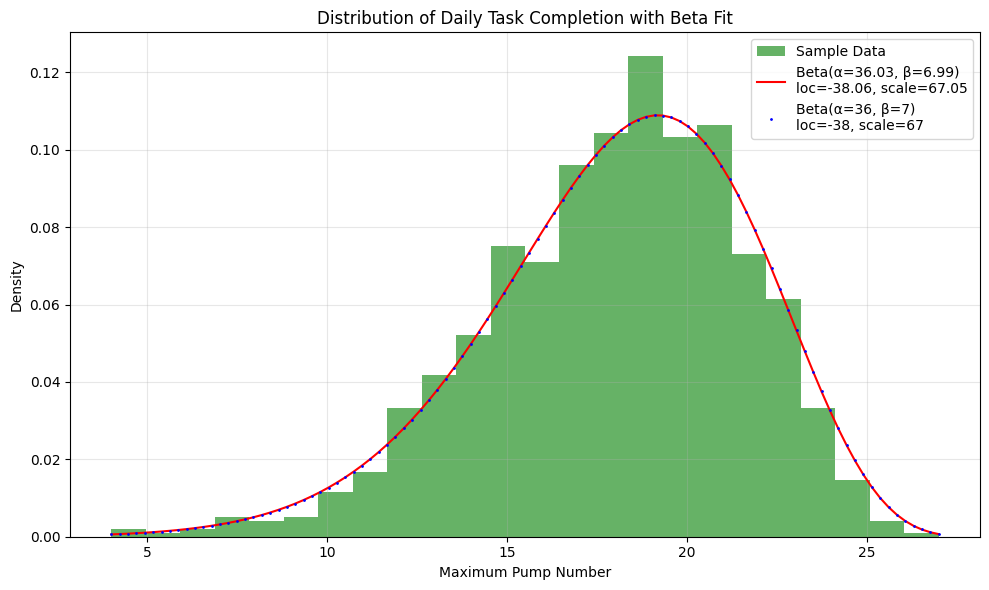

Fit parameters:
α (alpha): 36.028
β (beta):  6.995
loc:       -38.058
scale:     67.047


In [277]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Fit Beta distribution to original data
# Add small epsilon to avoid numerical issues at boundaries
eps = 1e-10
samples_adj = np.clip(samples, samples.min() + eps, samples.max() - eps)
alpha_hat, beta_hat, loc_hat, scale_hat = beta.fit(samples_adj)

# Create points for plotting
x = np.linspace(samples.min(), samples.max(), 100)
fitted_pdf = beta.pdf(x, alpha_hat, beta_hat, loc=loc_hat, scale=scale_hat)
fitted_pdf_rounded = beta.pdf(x, 36, 7, loc=-38, scale=67)

# Plot with improved formatting
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=24, density=True, alpha=0.6, color='g', label="Sample Data")
plt.plot(x, fitted_pdf, 'r-', 
         label=f'Beta(α={alpha_hat:.2f}, β={beta_hat:.2f})\nloc={loc_hat:.2f}, scale={scale_hat:.2f}')
plt.plot(x, fitted_pdf_rounded, 'b.', markersize=2,
         label='Beta(α=36, β=7)\nloc=-38, scale=67')

# Add labels and formatting
plt.xlabel("Maximum Pump Number")
plt.ylabel("Density")
plt.title("Distribution of Daily Task Completion with Beta Fit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print fit parameters
print(f"Fit parameters:")
print(f"α (alpha): {alpha_hat:.3f}")
print(f"β (beta):  {beta_hat:.3f}")
print(f"loc:       {loc_hat:.3f}")
print(f"scale:     {scale_hat:.3f}")

In [251]:
# Calculate summary statistics
mean_samples = np.mean(samples)
median_samples = np.median(samples)
std_samples = np.std(samples)
min_samples = np.min(samples)
max_samples = np.max(samples)
total_samples = len(samples)

print(f"Sample statistics:")
print(f"Mean: {mean_samples:.2f}")
print(f"Median: {median_samples:.2f}")
print(f"Standard Deviation: {std_samples:.2f}")
print(f"Minimum: {min_samples}")
print(f"Maximum: {max_samples}")
print(f"Total days: {total_samples}")

Daily participant sample statistics:
Mean: 18.09
Median: 18.50
Standard Deviation: 3.73
Minimum: 4
Maximum: 27
Total days: 1000


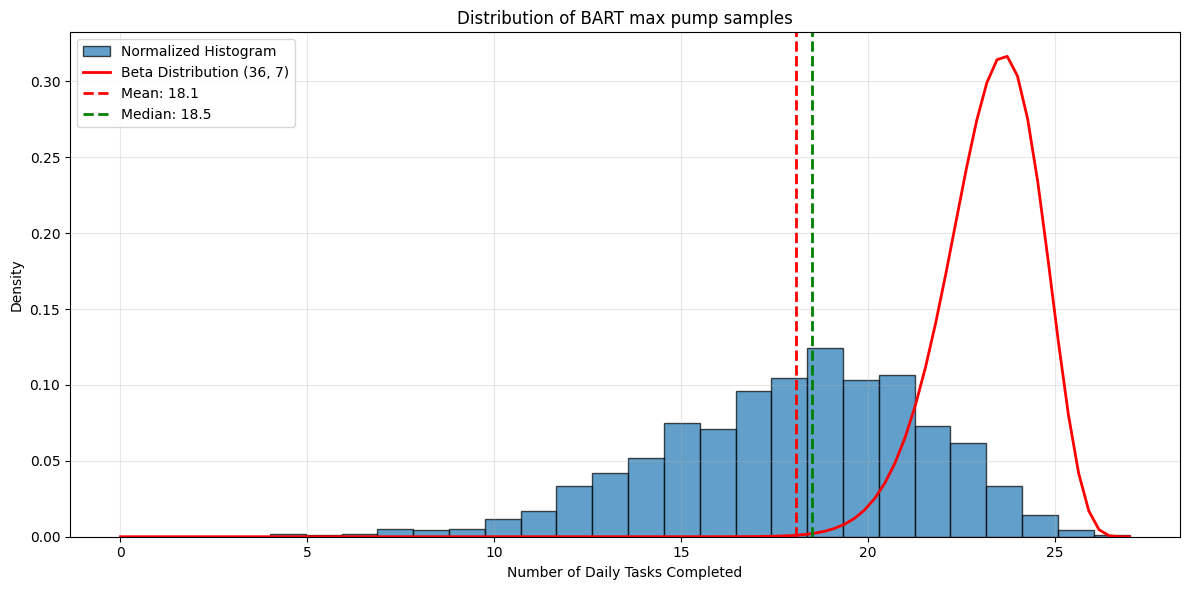

In [259]:
from scipy import stats

# Create histogram of samples with density=True to normalize
plt.figure(figsize=(12, 6))
plt.hist(samples, bins=24, density=True, edgecolor='black', alpha=0.7, label='Normalized Histogram')

# Add beta distribution curve
x = np.linspace(0, max_samples, 100)
# Scale and shift the beta distribution to match the range of the data
beta_y = stats.beta.pdf((x - min_samples) / (max_samples - min_samples), 36, 7)
# Scale beta distribution to match the data range
beta_y = beta_y / (max_samples - min_samples)
plt.plot(x, beta_y, 'r-', lw=2, label='Beta Distribution (36, 7)')

# Add labels and title
plt.xlabel('Number of Daily Tasks Completed')
plt.ylabel('Density')
plt.title('Distribution of BART max pump samples')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add mean and median lines
plt.axvline(mean_samples, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_samples:.1f}')
plt.axvline(median_samples, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_samples:.1f}')

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()


In [244]:
# Prepare the data without centering
model_data = df_good[['PID', 'day', 'composite_gap']].dropna()

# Fit the mixed linear model with raw day values
mlm = MixedLM(
    endog=model_data['composite_gap'],
    exog=sm.add_constant(model_data['day']),
    groups=model_data['PID'],
    exog_re=sm.add_constant(model_data['day'])  # Random slopes and intercepts
)

# Fit the model
mlm_fit = mlm.fit()

# Print summary
print(mlm_fit.summary())

# Extract random effects
random_effects = pd.DataFrame(
    mlm_fit.random_effects,
    columns=['random_intercept', 'random_slope']
)

# Create visualization of individual trajectories
plt.figure(figsize=(12, 6))

# Plot individual regression lines for a random sample of participants
sample_pids = np.random.choice(df_good['PID'].unique(), min(20, len(df_good['PID'].unique())), replace=False)

for pid in sample_pids:
    pid_data = df_good[df_good['PID'] == pid]
    
    # Get random effects for this participant
    re = random_effects.loc[pid]
    
    # Calculate predicted values using raw day values
    x = pid_data['day']
    y_pred = (mlm_fit.fe_params['const'] + re['random_intercept'] + 
              (mlm_fit.fe_params['day'] + re['random_slope']) * x)
    
    plt.plot(pid_data['day'], y_pred, alpha=0.3, color='gray')

# Plot population-level trend
x_pop = np.array([df_good['day'].min(), df_good['day'].max()])
y_pop = mlm_fit.fe_params['const'] + mlm_fit.fe_params['day'] * x_pop

plt.plot(x_pop, y_pop, 'r--', linewidth=2, label='Population trend')

plt.xlabel('Day')
plt.ylabel('Composite Gap')
plt.title('Individual Trajectories and Population Trend of Composite Gap Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print key findings
print("\nKey Findings:")
print(f"Fixed effect of time (population slope): {mlm_fit.fe_params['day']:.4f}")
print(f"Average composite gap at day 0 (population intercept): {mlm_fit.fe_params['const']:.4f}")
print("\nRandom Effects Standard Deviations:")
print(f"Intercept SD: {np.sqrt(mlm_fit.cov_re.iloc[0,0]):.4f}")
print(f"Slope SD: {np.sqrt(mlm_fit.cov_re.iloc[1,1]):.4f}")

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: composite_gap
No. Observations: 7747    Method:             REML         
No. Groups:       105     Scale:              386.3748     
Min. group size:  41      Log-Likelihood:     -34303.7303  
Max. group size:  84      Converged:          Yes          
Mean group size:  73.8                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
const            44.528    1.225 36.351 0.000 42.127 46.928
day              -0.089    0.019 -4.766 0.000 -0.126 -0.053
const Var       135.451    1.121                           
const x day Cov  -0.626    0.013                           
day Var           0.027    0.000                           



KeyError: '1dd79a79-dd14-4932-b81b-16f95bbcd796'

<Figure size 1200x600 with 0 Axes>

# Data Preprocessing

## Train-Test Split

Perform train-test split based on the last day of data collection where a subject had 
data for the SensorKit (based on unlock duration data)

In [ ]:
# Create splits for both dataframes
train_data, test_data = create_train_test_split(df)

print("Passive data splits:")
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Number of unique PIDs in training: {train_data['PID'].nunique()}")
print(f"Number of unique PIDs in test: {test_data['PID'].nunique()}")

Passive data splits:
Training set size: 5080
Test set size: 1334
Number of unique PIDs in training: 104
Number of unique PIDs in test: 104


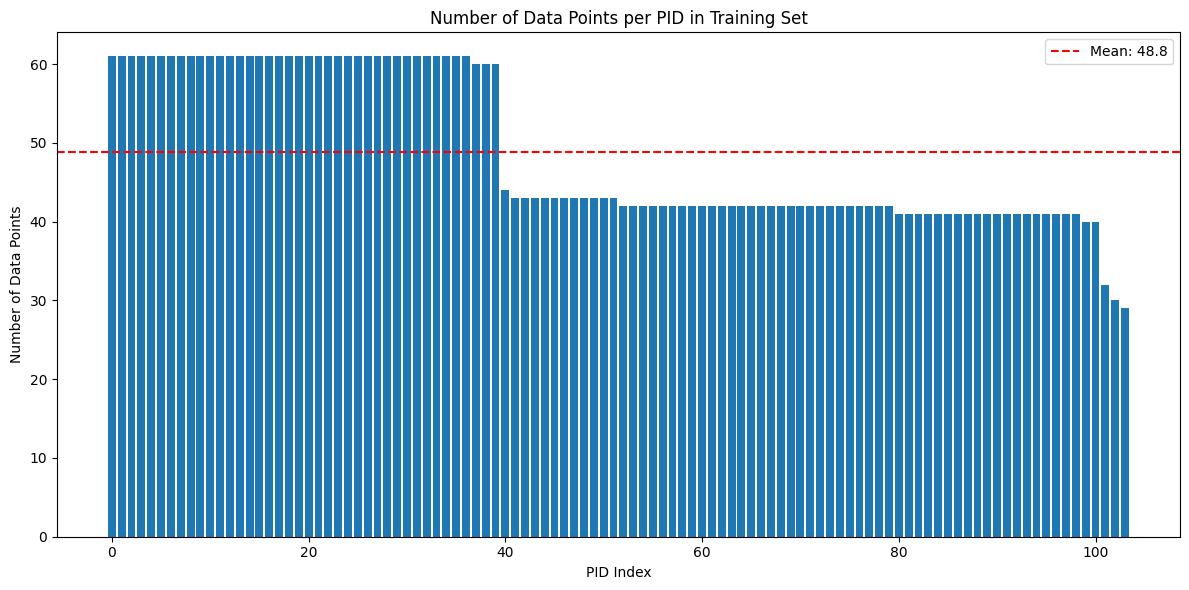

In [ ]:
# Count data points per PID in training set
pid_counts = train_data['PID'].value_counts()

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(pid_counts)), pid_counts.values)
plt.xlabel('PID Index')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per PID in Training Set')

# Add mean line
mean_points = pid_counts.mean()
plt.axhline(y=mean_points, color='r', linestyle='--', label=f'Mean: {mean_points:.1f}')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Check for empty, binary (0/1) columns and non-numeric columns
empty_cols = []
binary_cols = []
non_numeric_cols = []

for col in train_data.columns:
    # Check if column is empty (all NaN)
    if train_data[col].isna().all():
        empty_cols.append(col)
        continue
        
    # Check if column is non-numeric
    if not np.issubdtype(train_data[col].dtype, np.number):
        non_numeric_cols.append(col)
        continue
        
    # Check if column only contains 0s and 1s
    unique_vals = train_data[col].unique()
    unique_vals = unique_vals[~np.isnan(unique_vals)]  # Remove NaN values
    if set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)

print("Empty columns:")
print(empty_cols)
print("\nBinary columns:")
print(binary_cols)
print("\nNon-numeric columns:")
print(non_numeric_cols)


Empty columns:
[]

Binary columns:
['task_emoStroop_trying', 'task_gng_trying', 'task_nback_mode_hard', 'survey_complete', 'tasks_complete', 'watch_wearing', 'weekend', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'fe_lag_1_task_emoStroop_trying', 'fe_lag_2_task_emoStroop_trying', 'fe_lag_3_task_emoStroop_trying', 'fe_lag_1_task_gng_trying', 'fe_lag_2_task_gng_trying', 'fe_lag_3_task_gng_trying', 'fe_lag_1_task_nback_mode_hard', 'fe_lag_2_task_nback_mode_hard', 'fe_lag_3_task_nback_mode_hard', 'fe_lag_1_survey_complete', 'fe_lag_2_survey_complete', 'fe_lag_3_survey_complete', 'fe_lag_1_tasks_complete', 'fe_lag_2_tasks_complete', 'fe_lag_3_tasks_complete', 'fe_lag_1_watch_wearing', 'fe_lag_2_watch_wearing', 'fe_lag_3_watch_wearing', 'fe_rollingSD_7_affect_pct_zeroVarRows', 'fe_rollingSD_7_task_hanoi_movesTime_model_startPoint', 'fe_rollingSD_7_task_hanoi_movesTime_model_decay', 'fe_rollingSD_7_task_hanoi_movesTime

## Create CV folds

In [244]:
# Create CV folds
cv_folds = expanding_window_cv_nested(train_data_clean)

## Select Features

In [245]:
# Filter features from mlm_gap_df where abs_t_value > 1 and exclude 'css' features
features = [f for f in mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist() 
                       if 'css' not in f]

print(f"Selected {len(features)} features with |t| > 2 (excluding css features):")

Selected 65 features with |t| > 1 (excluding css features):


In [205]:
df_good = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_42557/3480574736.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_good = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv')


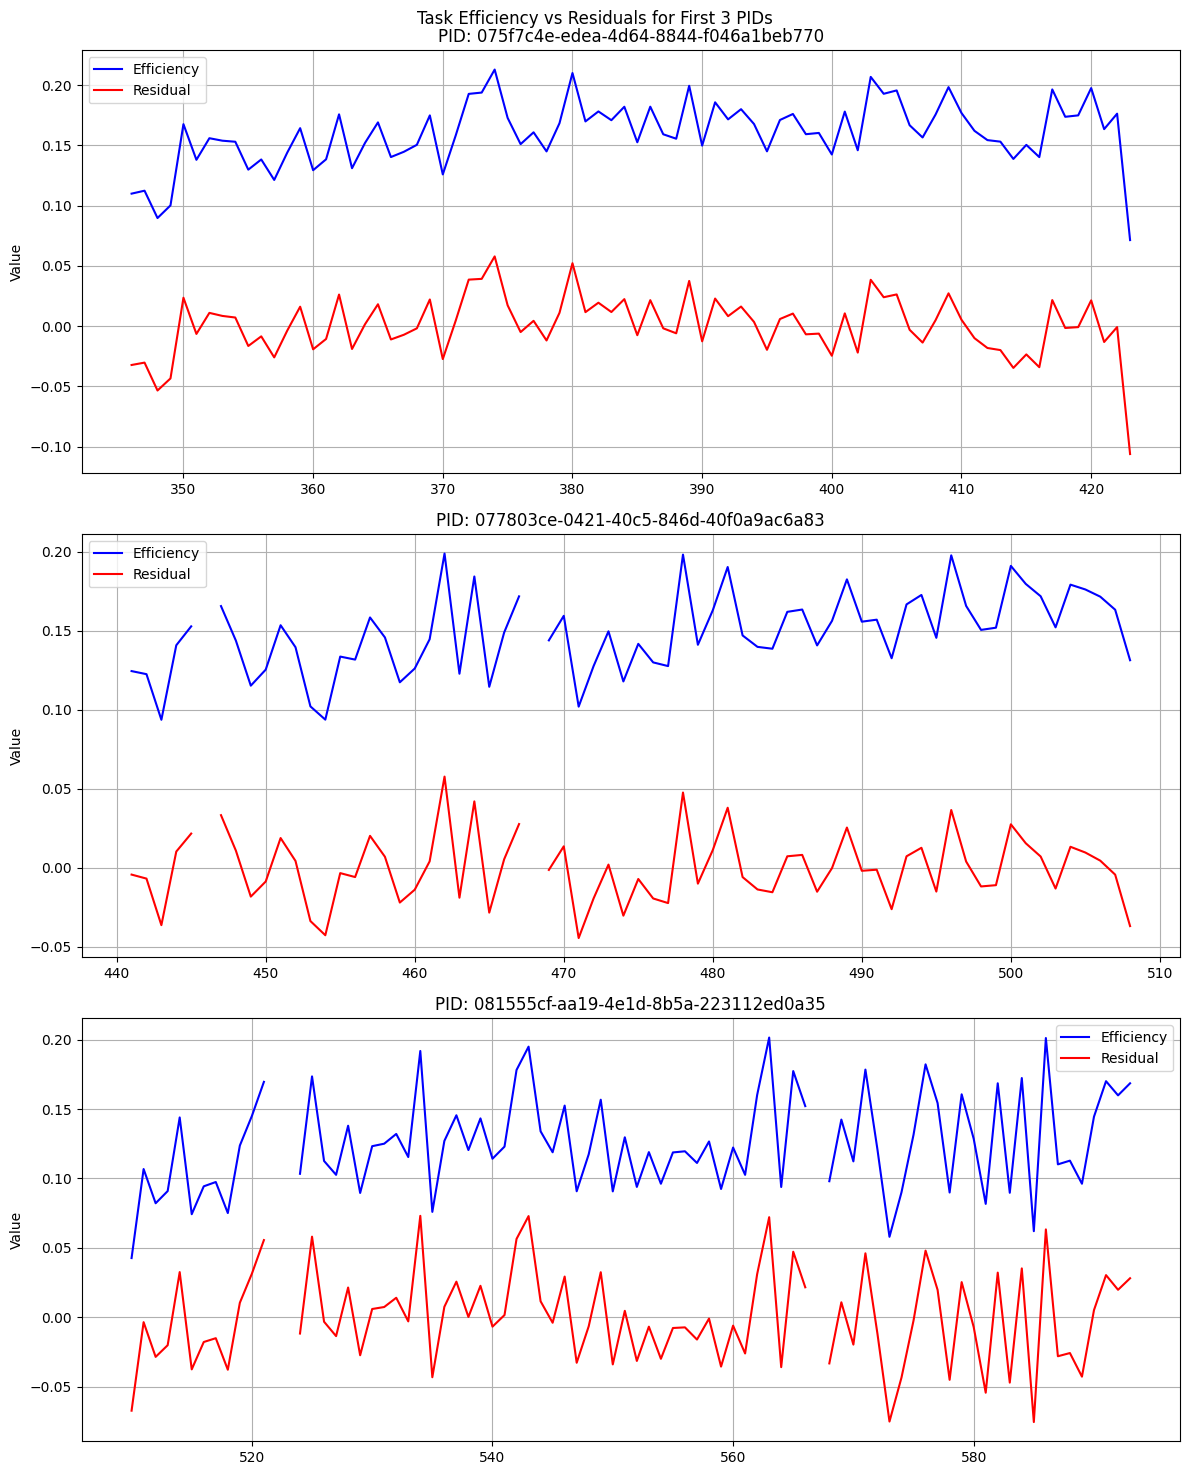

In [225]:
# Get first 3 PIDs
first_3_pids = df_good['PID'].unique()[4:7]

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle('Task Efficiency vs Residuals for First 3 PIDs')

for i, pid in enumerate(first_3_pids):
    pid_data = df_good[df_good['PID'] == pid]
    
    # Plot efficiency
    axes[i].plot(pid_data.index, pid_data['task_trailmaking_efficiency'], 
                label='Efficiency', color='blue')
    
    # Plot residuals
    axes[i].plot(pid_data.index, pid_data['task_trailmaking_efficiency_model_residual'], 
                label='Residual', color='red')
    
    axes[i].set_title(f'PID: {pid}')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()


In [217]:
# Get first PID
first_pid = df_good['PID'].iloc[0]

# Calculate mean task_emoStroop_efficiency for first PID
mean_efficiency = df_good[df_good['PID'] == first_pid]['task_emoStroop_efficiency'].mean()
print(f"Mean task_emoStroop_efficiency for PID {first_pid}: {mean_efficiency:.6f}")


Mean task_emoStroop_efficiency for PID 0151d9f1-1644-4437-805e-02f5e244a690: 0.989865


In [216]:
# Get first PID
first_pid = df_good['PID'].iloc[0]

# Calculate mean residual for first PID
mean_residual = df_good[df_good['PID'] == first_pid]['task_emoStroop_efficiency_model_residual'].mean()
print(f"Mean task_emoStroop_efficiency_model_residual for PID {first_pid}: {mean_residual:.6f}")


Mean task_emoStroop_efficiency_model_residual for PID 0151d9f1-1644-4437-805e-02f5e244a690: 0.005841


In [215]:
df_good['task_emoStroop_efficiency_model_residual']

0      -0.048031
1      -0.053578
2      -0.015549
3      -0.021088
4      -0.024091
          ...   
8920    0.282788
8921   -0.280287
8922         NaN
8923    0.094557
8924         NaN
Name: task_emoStroop_efficiency_model_residual, Length: 8925, dtype: float64

In [213]:
# Check if task_emoStroop_efficiency values match either residual column
print("Checking task_emoStroop_efficiency correlations with residual columns:")

if 'task_emoStroop_efficiency' in df.columns:
    if 'task_emoStroop_efficiency_model_residual_norm' in df_good.columns:
        # Get correlation with normalized residuals
        valid_pairs = pd.merge(
            df[['task_emoStroop_efficiency']], 
            df_good[['task_emoStroop_efficiency_model_residual_norm']],
            left_index=True, right_index=True
        )
        corr = valid_pairs['task_emoStroop_efficiency'].corr(valid_pairs['task_emoStroop_efficiency_model_residual_norm'])
        print(f"Correlation with normalized residuals: {corr:.3f}")
    
    if 'task_emoStroop_efficiency_model_residual' in df_good.columns:
        # Get correlation with raw residuals
        valid_pairs = pd.merge(
            df[['task_emoStroop_efficiency']], 
            df_good[['task_emoStroop_efficiency_model_residual']],
            left_index=True, right_index=True
        )
        corr = valid_pairs['task_emoStroop_efficiency'].corr(valid_pairs['task_emoStroop_efficiency_model_residual'])
        print(f"Correlation with raw residuals: {corr:.3f}")
else:
    print("task_emoStroop_efficiency not found in original dataframe")


Checking task_emoStroop_efficiency correlations with residual columns:
Correlation with normalized residuals: -0.006
Correlation with raw residuals: -0.003


In [211]:
df.columns[df.columns.str.contains('efficiency')]

Index(['task_psat_efficiency', 'task_stroop_efficiency',
       'task_emoStroop_efficiency',
       'task_emoStroop_efficiency_model_intercept',
       'task_emoStroop_efficiency_model_slope', 'task_trailmaking_efficiency',
       'task_trailmaking_efficiency_model_intercept',
       'task_trailmaking_efficiency_model_slope',
       'fe_lag_1_task_psat_efficiency', 'fe_lag_2_task_psat_efficiency',
       'fe_lag_3_task_psat_efficiency', 'fe_lag_1_task_stroop_efficiency',
       'fe_lag_2_task_stroop_efficiency', 'fe_lag_3_task_stroop_efficiency',
       'fe_lag_1_task_emoStroop_efficiency',
       'fe_lag_2_task_emoStroop_efficiency',
       'fe_lag_3_task_emoStroop_efficiency',
       'fe_lag_1_task_emoStroop_efficiency_model_intercept',
       'fe_lag_2_task_emoStroop_efficiency_model_intercept',
       'fe_lag_3_task_emoStroop_efficiency_model_intercept',
       'fe_lag_1_task_emoStroop_efficiency_model_slope',
       'fe_lag_2_task_emoStroop_efficiency_model_slope',
       'fe_lag_

In [212]:
df_good.columns[df_good.columns.str.contains('residual')]

Index(['task_hanoi_movesTime_model_residual',
       'task_psat_efficiency_model_residual',
       'task_stroop_efficiency_model_residual',
       'task_bart_score_model_residual',
       'task_spatialSpan_score_model_residual',
       'task_emoStroop_efficiency_model_residual',
       'task_gng_d_prime_model_residual',
       'task_trailmaking_efficiency_model_residual',
       'task_rt_avgRT_model_residual',
       'task_hanoi_movesTime_model_residual_norm',
       'task_psat_efficiency_model_residual_norm',
       'task_stroop_efficiency_model_residual_norm',
       'task_bart_score_model_residual_norm',
       'task_spatialSpan_score_model_residual_norm',
       'task_emoStroop_efficiency_model_residual_norm',
       'task_gng_d_prime_model_residual_norm',
       'task_trailmaking_efficiency_model_residual_norm',
       'task_rt_avgRT_model_residual_norm', 'sr_gap_heuristic_residual'],
      dtype='object')

In [200]:

# Get unique PIDs
unique_pids = df['PID'].unique()

# Shorten column names by removing '_model_residual'
shortened_column_names = [col.replace('_model_residual', '') for col in residual_columns]

# Remap the original column names to the shortened names for plotting
column_name_mapping = dict(zip(residual_columns, shortened_column_names))

# Reinitialize the figure for plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Correlation Matrices of Residual Columns by PID', fontsize=16)

# # Determine global min and max correlation values to standardize the color scale across all subplots
# # This ensures the color scale is consistent and 0 is accurately represented as the midpoint.
# global_min = min(pid_df.corr().min().min() for pid in unique_pids[:6])
# global_max = max(pid_df.corr().max().max() for pid in unique_pids[:6])
# vmin, vmax = min(global_min, -global_max), max(-global_min, global_max)

# Loop through the first 6 PIDs again, this time with shortened column names on the axes
for index, pid in enumerate(unique_pids[:6]):
    ax = axes[index // 3, index % 3]
    
    pid_df = df[df['PID'] == pid][residual_columns]
    # Rename columns for the current PID's dataframe for plotting
    pid_df = pid_df.rename(columns=column_name_mapping)
    correlation_matrix = pid_df.corr()
    
    # Determine global min and max correlation values to standardize the color scale across all subplots
    # This ensures the color scale is consistent and 0 is accurately represented as the midpoint.
    global_min = min(pid_df.corr().min().min() for pid in unique_pids[:6])
    global_max = max(pid_df.corr().max().max() for pid in unique_pids[:6])
    vmin, vmax = min(global_min, -global_max), max(-global_min, global_max)
    
    # Adjust 'vmin' and 'vmax' for the heatmap to center the color scale at 0
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax, cbar=False, center=0, vmin=vmin, vmax=vmax)
    ax.set_title(f'PID: {pid}')
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title and x-axis labels
plt.show()

NameError: name 'residual_columns' is not defined

In [199]:
# Calculate correlation between task_psat_efficiency and target_wbw_gap using pairwise complete observations
valid_pairs = df[['css', 'target_wbw_gap']].dropna()
corr = valid_pairs['css'].corr(valid_pairs['target_wbw_gap'])
print(f"\nCorrelation between CSS and well-being gap: {corr:.3f}")



Correlation between CSS and well-being gap: -0.019


In [193]:
# Sort by absolute correlation but keep original correlation value
correlations_sorted = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)

# Filter and print top 25 correlations for each category
print("\nTop 25 Passive Feature Correlations:")
passive_correlations = [(f, c) for f, c in correlations_sorted if f in passive_cols][:25]
for feature, corr in passive_correlations:
    print(f"{feature}: {corr:.3f}")

print("\nTop 25 Self-Report Feature Correlations:")
sr_correlations = [(f, c) for f, c in correlations_sorted if f in sr_cols][:25]
for feature, corr in sr_correlations:
    print(f"{feature}: {corr:.3f}")

print("\nTop 25 Task Feature Correlations:")
task_correlations = [(f, c) for f, c in correlations_sorted if f in task_cols][:25]
for feature, corr in task_correlations:
    print(f"{feature}: {corr:.3f}")


Top 25 Passive Feature Correlations:
fe_rollingSD_7_passive_sk_visits_school_elapsed: -0.119
passive_hk_activity_steps: -0.112
passive_hk_activity_distanceWalkingRunning: -0.112
fe_rollingSD_7_passive_sk_keyboard_total_autocorrections: -0.108
fe_rollingSD_7_passive_sk_keyboard_total_words: -0.108
passive_hk_activity_appleStandTime: -0.105
fe_rollingSD_7_passive_hk_sleep_inBed: 0.097
fe_rollingSD_7_passive_sk_keyboard_total_typing_episodes: -0.088
fe_rollingSD_7_passive_sk_keyboard_typing_speed: 0.082
passive_sk_device_total_screen_wakes: -0.081
fe_rollingSD_7_passive_sk_telephony_speakingRate_variance: -0.081
fe_rollingSD_7_passive_sk_keyboard_total_typing_duration: -0.077
passive_sk_visits_home_elapsed: 0.076
fe_rollingSD_7_passive_hk_activity_averageWalkingSpeed: 0.075
fe_rollingSD_7_passive_sk_messages_outgoing: -0.074
survey_complete: -0.072
fe_rollingSD_7_passive_sk_calls_duration: -0.071
passive_hk_activity_activeEnergyBurned: -0.068
fe_rollingSD_7_passive_sk_keyboard_total_paus

## Feature Engineering

In [429]:
# list of features that do not include string 'fe'
fe_features = [f for f in features if 'fe' not in f]

# remove dummy coded days
fe_features = [f for f in fe_features if 'weekend' not in f and 'day_of_week' not in f]

# add t_current to features
fe_features.append('t_current')

In [431]:
# # Calculate median and sd for each feature within PID groups for train_data_clean
# pid_stats_clean = train_data_clean.groupby('PID')[fe_features].agg(['median', 'std']).reset_index()

# # Flatten multi-level column names with 'agg_' prefix
# pid_stats_clean.columns = ['PID'] + [f'agg_{col[0]}_{col[1]}' for col in pid_stats_clean.columns[1:]]

# Calculate median and sd for each feature within PID groups for train_data_all_clean
pid_stats_all = train_data_all_clean.groupby('PID')[fe_features].agg(['median', 'std']).reset_index()

# Flatten multi-level column names with 'agg_' prefix
pid_stats_all.columns = ['PID'] + [f'agg_{col[0]}_{col[1]}' for col in pid_stats_all.columns[1:]]

# Merge stats back to train and test data
# train_data_clean = train_data_clean.merge(pid_stats_clean, on='PID', how='left')
# test_data_clean = test_data_clean.merge(pid_stats_clean, on='PID', how='left')
train_data_all_clean = train_data_all_clean.merge(pid_stats_all, on='PID', how='left')
test_data_all_clean = test_data_all_clean.merge(pid_stats_all, on='PID', how='left')

# Add the new feature names to the features list
for f in fe_features:
    features.extend([f'agg_{f}_median', f'agg_{f}_std'])

In [432]:
# Create alt features list without agg_ features except for t_current
alt_features = [f for f in features if not ('agg_' in f) or 't_current' in f]
print(f"\nSelected {len(alt_features)} features (excluding agg_ features except t_current):")


Selected 52 features (excluding agg_ features except t_current):


## Normalize Data

In [433]:
# Get features to normalize (exclude t_current, agg_, and binary features)
features_to_normalize = [f for f in train_data_clean.columns 
                        if 't_current' not in f 
                        and not f.startswith('agg_')
                        and f != 'PID'
                        and f != 'trial_date'
                        and f != 'day'
                        and f != 'cohort'
                        and train_data_clean[f].nunique() > 2]

features_to_normalize_all = [f for f in train_data_all_clean.columns 
                           if 't_current' not in f 
                           and not f.startswith('agg_')
                           and f != 'PID'
                           and f != 'trial_date'
                           and f != 'day'
                           and f != 'cohort'
                           and train_data_all_clean[f].nunique() > 2]

# Store normalization parameters for each PID
pid_norm_params = {}
pid_norm_params_all = {}

# Calculate normalization parameters from training data and normalize train data
for pid in train_data_clean['PID'].unique():
    pid_mask = train_data_clean['PID'] == pid
    pid_norm_params[pid] = {
        'mean': train_data_clean.loc[pid_mask, features_to_normalize].mean(),
        'std': train_data_clean.loc[pid_mask, features_to_normalize].std()
    }
    
    # Normalize training data
    train_data_clean.loc[pid_mask, features_to_normalize] = (
        train_data_clean.loc[pid_mask, features_to_normalize] - pid_norm_params[pid]['mean']
    ) / pid_norm_params[pid]['std']

for pid in train_data_all_clean['PID'].unique():
    pid_mask = train_data_all_clean['PID'] == pid
    pid_norm_params_all[pid] = {
        'mean': train_data_all_clean.loc[pid_mask, features_to_normalize_all].mean(),
        'std': train_data_all_clean.loc[pid_mask, features_to_normalize_all].std()
    }
    
    # Normalize training data
    train_data_all_clean.loc[pid_mask, features_to_normalize_all] = (
        train_data_all_clean.loc[pid_mask, features_to_normalize_all] - pid_norm_params_all[pid]['mean']
    ) / pid_norm_params_all[pid]['std']

# Normalize test data using parameters from training data
for pid in test_data_clean['PID'].unique():
    if pid in pid_norm_params:  # Only normalize if we have params from training
        pid_mask = test_data_clean['PID'] == pid
        test_data_clean.loc[pid_mask, features_to_normalize] = (
            test_data_clean.loc[pid_mask, features_to_normalize] - pid_norm_params[pid]['mean']
        ) / pid_norm_params[pid]['std']

for pid in test_data_all_clean['PID'].unique():
    if pid in pid_norm_params_all:  # Only normalize if we have params from training
        pid_mask = test_data_all_clean['PID'] == pid
        test_data_all_clean.loc[pid_mask, features_to_normalize_all] = (
            test_data_all_clean.loc[pid_mask, features_to_normalize_all] - pid_norm_params_all[pid]['mean']
        ) / pid_norm_params_all[pid]['std']

## Split Data

In [255]:
# Split data
X_train = train_data_clean[features]
y_train = train_data_clean['t_current']

X_test = test_data_clean[features]
y_test = test_data_clean['t_current']

In [434]:
# Split data
X_train = train_data_all_clean[features]
y_train = train_data_all_clean['t_current']

X_test = test_data_all_clean[features]
y_test = test_data_all_clean['t_current']

# XGBoost

## Overfit

In [154]:
# Import XGBoost
import xgboost as xgb

In [155]:
# Create and train XGBoost model with parameters that will cause extreme overfitting
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,        # Increased number of trees
    learning_rate=0.3,        # Increased learning rate
    max_depth=15,            # Much deeper trees
    min_child_weight=1,      # Allow very specific splits
    subsample=1.0,           # Use all samples for each tree
    colsample_bytree=1.0,    # Use all features for each tree
    reg_alpha=0,             # No L1 regularization
    reg_lambda=0,            # No L2 regularization
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions on both train and test sets
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

XGBoost Results:
Training RMSE: 0.001
Training MAE: 0.000
Test RMSE: 17.131
Test MAE: 13.225


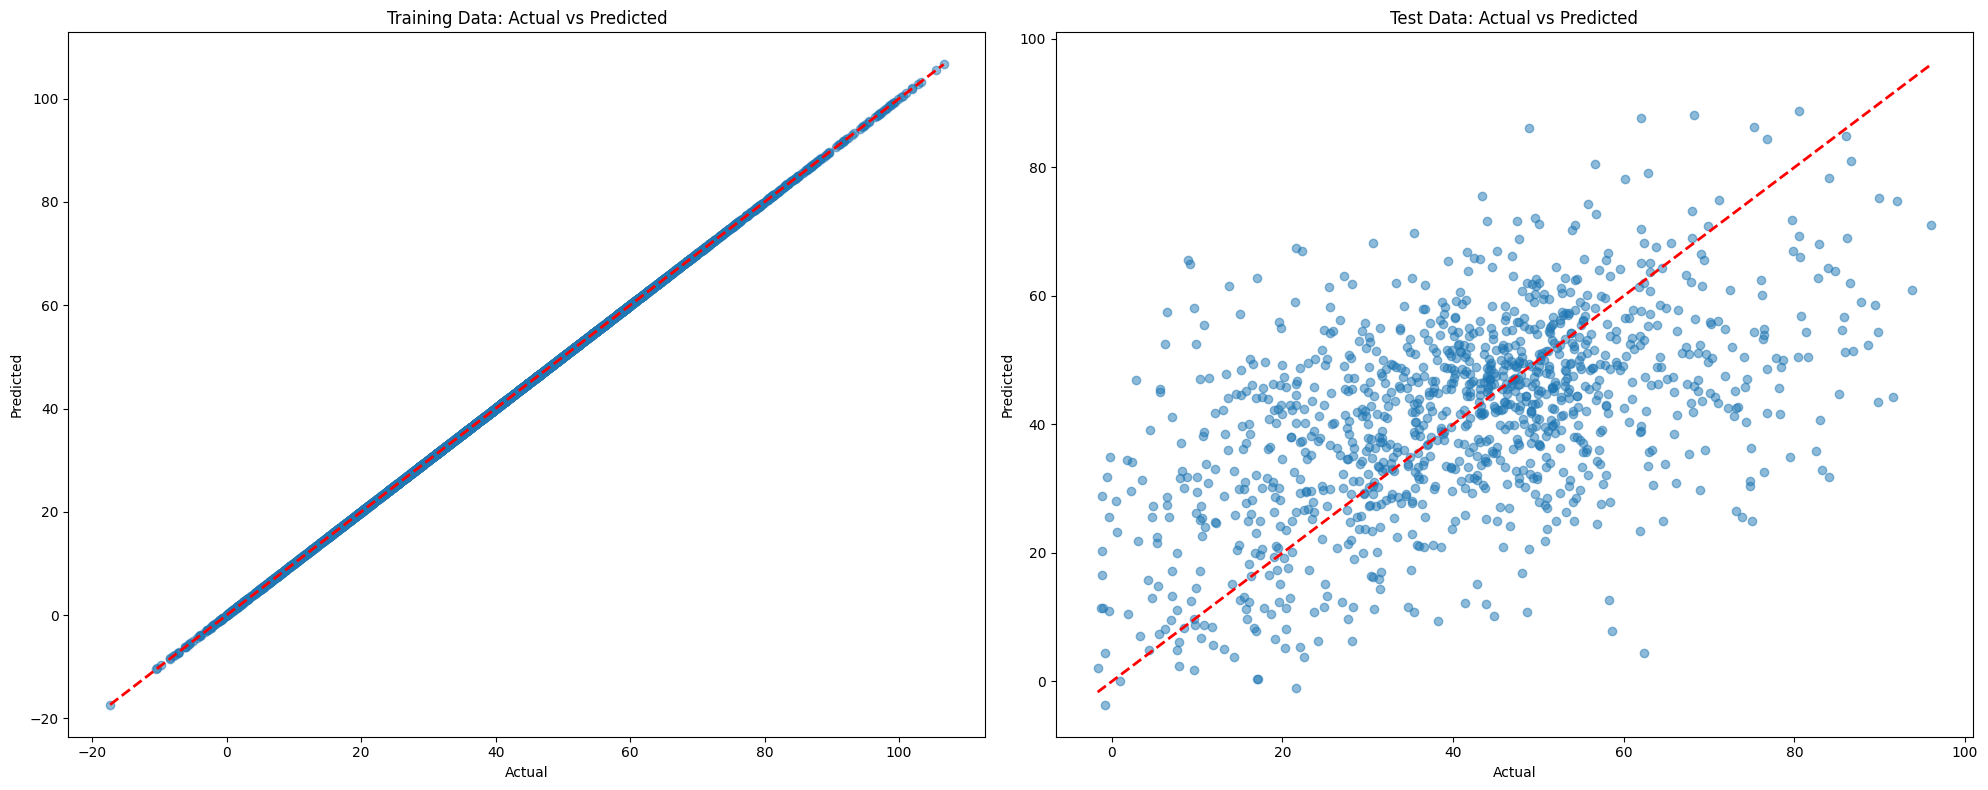

In [156]:
# Calculate metrics for training data
train_rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
train_mae = np.mean(np.abs(y_train - y_pred_train))

# Calculate metrics for test data
test_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
test_mae = np.mean(np.abs(y_test - y_pred_test))

print("XGBoost Results:")
print(f"Training RMSE: {train_rmse:.3f}")
print(f"Training MAE: {train_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}") 
print(f"Test MAE: {test_mae:.3f}")

# Plot actual vs predicted for both train and test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training data plot
ax1.scatter(y_train, y_pred_train, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Training Data: Actual vs Predicted')

# Test data plot
ax2.scatter(y_test, y_pred_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('Test Data: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [131]:
# give the model the normalized passive data and the raw mean and sd for each subject for ALL training data

# how well does this do versus something that just has the mean of the gap

# what if you ONLY knew about their passive data...can we predict their mean??

# how much data about someones mean do we need in order to predict their gap?
## i.e. one day of data re: their gap, what about 1 week, all training data?

#----#

# Look at an individual model using XGBoost - use hyperparameters from group?
# Combine individual and group (experiment with combination level)

## Fitted

### Continuous

[I 2025-01-15 14:05:48,836] A new study created in memory with name: no-name-3c8ee282-328e-4999-961d-f6b3b2db7eff


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-15 14:05:55,399] Trial 0 finished with value: 13.84416114418805 and parameters: {'n_estimators': 335, 'max_depth': 6, 'learning_rate': 0.013179876797915524, 'min_child_weight': 3, 'subsample': 0.8271716783884424, 'colsample_bytree': 0.7675096699600488, 'reg_alpha': 0.15108246445920653, 'reg_lambda': 0.10304668509110708}. Best is trial 0 with value: 13.84416114418805.
[I 2025-01-15 14:05:57,387] Trial 1 finished with value: 13.859127680690118 and parameters: {'n_estimators': 478, 'max_depth': 5, 'learning_rate': 0.044330185386830714, 'min_child_weight': 1, 'subsample': 0.8500119438463067, 'colsample_bytree': 0.9030085310612928, 'reg_alpha': 0.41877373207814644, 'reg_lambda': 0.11336389611261462}. Best is trial 0 with value: 13.84416114418805.
[I 2025-01-15 14:05:58,610] Trial 2 finished with value: 13.75641995694446 and parameters: {'n_estimators': 438, 'max_depth': 3, 'learning_rate': 0.06347041512391627, 'min_child_weight': 2, 'subsample': 0.7679751283879859, 'colsample_byt

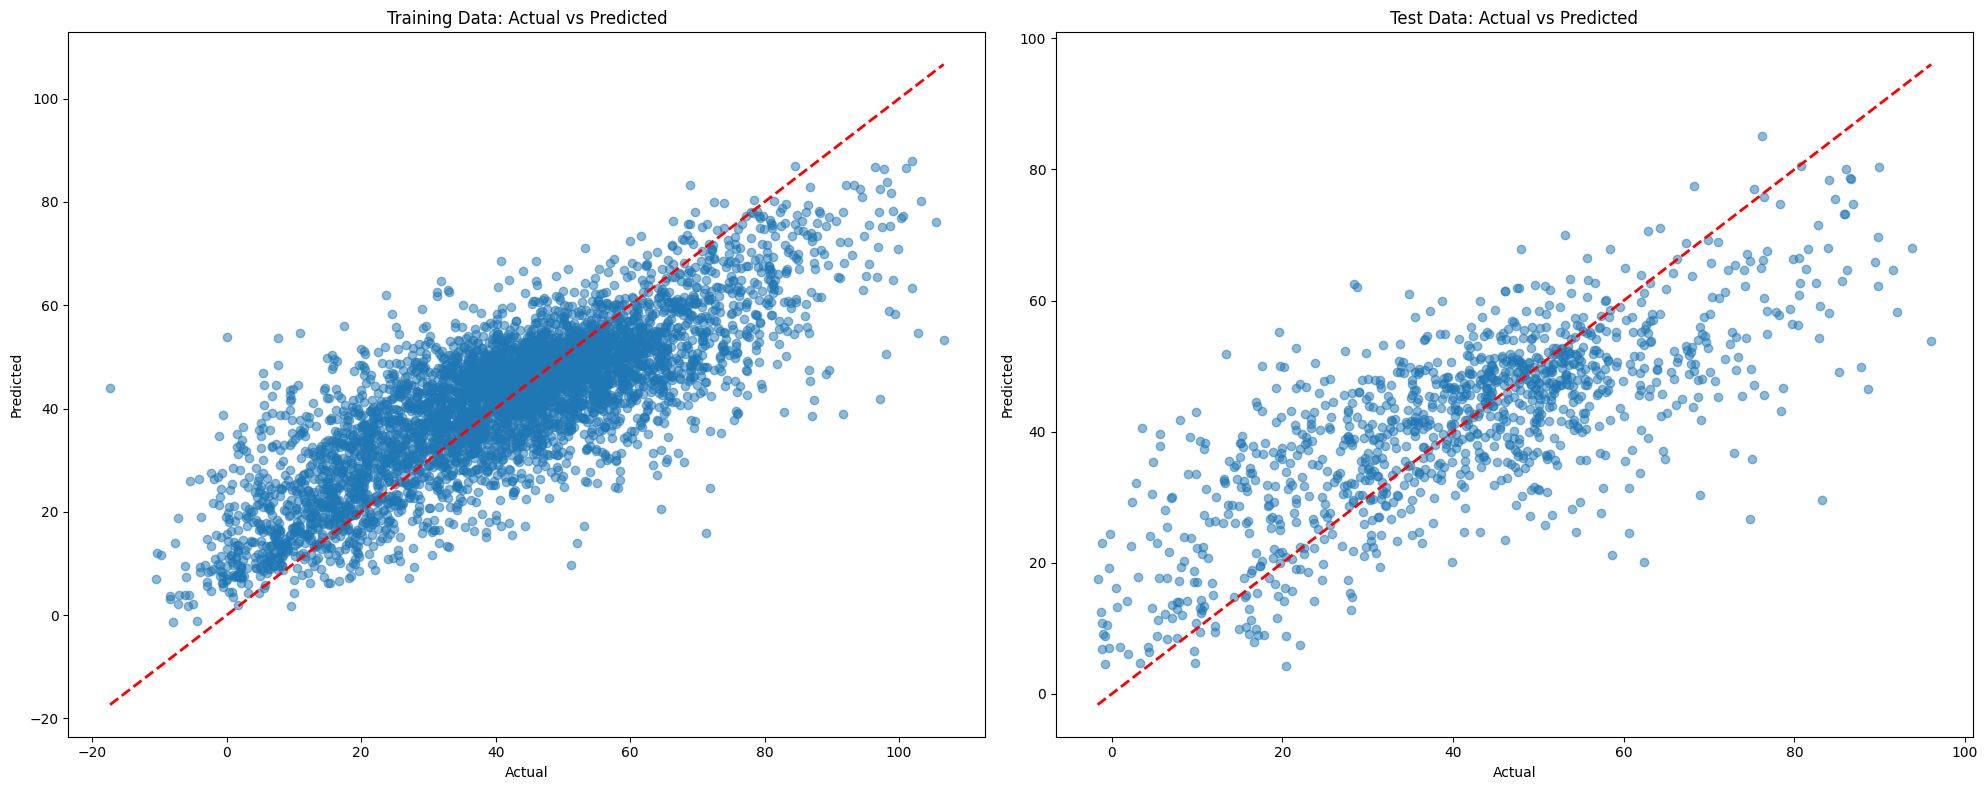

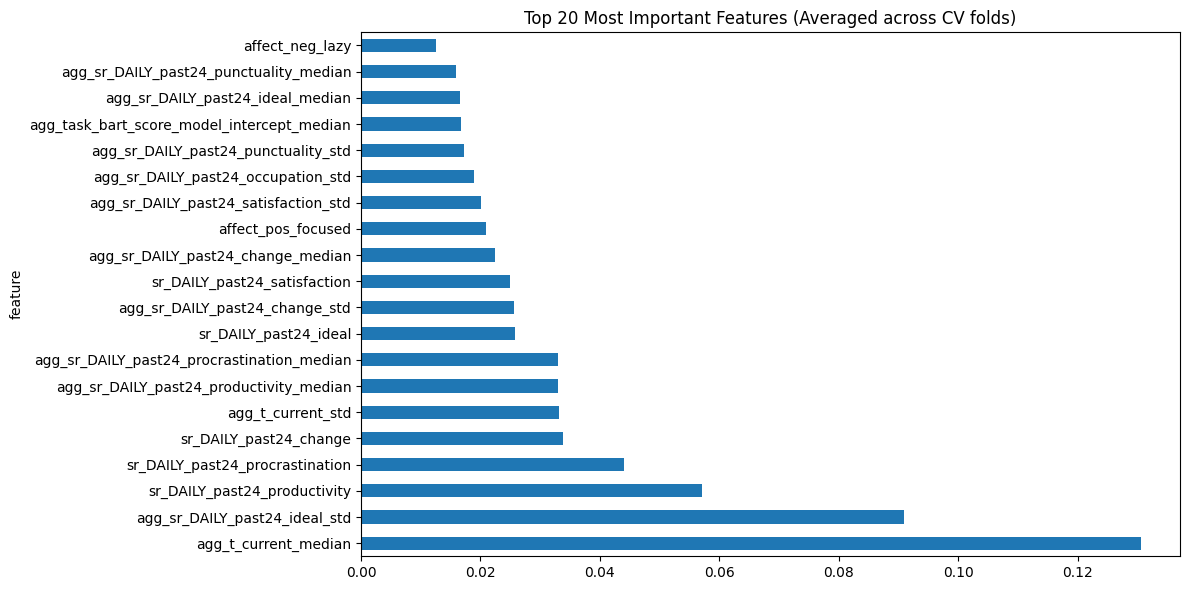

In [436]:
# Import required libraries
import optuna
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial, X, y, cv_folds):
    # Define hyperparameter search space with balanced ranges
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 6),  # Moderate depth
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Moderate learning rate
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),  # Balanced min_child_weight
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Moderate subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # Moderate feature sampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0, log=True),  # Moderate L1
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0, log=True),  # Moderate L2
        'random_state': 42,
        'early_stopping_rounds': 30  # Balanced early stopping
    }
    
    fold_scores = []
    
    # Perform cross-validation
    for train_idx, val_idx in cv_folds:
        model = xgb.XGBRegressor(**params)
        model.fit(
            X.iloc[train_idx], 
            y.iloc[train_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            verbose=False
        )
        
        # Evaluate on validation set
        val_preds = model.predict(X.iloc[val_idx])
        fold_score = np.sqrt(mean_squared_error(y.iloc[val_idx], val_preds))
        fold_scores.append(fold_score)
    
    return np.mean(fold_scores)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, X_train, y_train, cv_folds), 
    n_trials=50,
    show_progress_bar=True
)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'random_state': 42,
    'early_stopping_rounds': 30
})

print("\nBest parameters found:", best_params)

# Train final model with best parameters using cross-validation
cv_scores = []
cv_models = []

for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
    fold_model = xgb.XGBRegressor(**best_params)
    fold_model.fit(
        X_train.iloc[train_idx], 
        y_train.iloc[train_idx],
        eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])],
        verbose=False
    )
    cv_models.append(fold_model)
    
    # Calculate fold score
    val_preds = fold_model.predict(X_train.iloc[val_idx])
    fold_score = np.sqrt(mean_squared_error(y_train.iloc[val_idx], val_preds))
    cv_scores.append(fold_score)

# Use model averaging for final predictions
y_pred_train = np.mean([model.predict(X_train) for model in cv_models], axis=0)
y_pred_test = np.mean([model.predict(X_test) for model in cv_models], axis=0)

# Calculate and print metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nCross-validation RMSE scores:", cv_scores)
print(f"Mean CV RMSE: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
print("\nFinal Model Results:")
print(f"Training RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Training MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")

# Plot actual vs predicted for both train and test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training data plot
ax1.scatter(y_train, y_pred_train, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Training Data: Actual vs Predicted')

# Test data plot
ax2.scatter(y_test, y_pred_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('Test Data: Actual vs Predicted')

plt.tight_layout()
plt.show()

# Plot feature importance
importance_dfs = []
for model in cv_models:
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    })
    importance_dfs.append(importance_df)

avg_importance = pd.concat(importance_dfs).groupby('feature')['importance'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_importance.head(20).plot(kind='barh')
plt.title('Top 20 Most Important Features (Averaged across CV folds)')
plt.tight_layout()
plt.show()

### Categorical: Median

#### Create Target

In [324]:
# Create binary target based on subject's median
train_data_clean['target_above_median'] = (train_data_clean['t_current'] > 
                                          train_data_clean['agg_t_current_median']).astype(int)
test_data_clean['target_above_median'] = (test_data_clean['t_current'] > 
                                         test_data_clean['agg_t_current_median']).astype(int)

# Update target variables
X_train = train_data_clean[features]
y_train = train_data_clean['target_above_median']
X_test = test_data_clean[features]
y_test = test_data_clean['target_above_median']

In [325]:
from sklearn.metrics import (roc_auc_score, accuracy_score, 
                           classification_report, roc_curve, log_loss)


[I 2025-01-13 14:49:17,699] A new study created in memory with name: no-name-d1d1fa71-aad4-4f91-b932-35c383ac730d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-13 14:49:18,379] Trial 0 finished with value: -0.5592984497852853 and parameters: {'n_estimators': 437, 'max_depth': 2, 'learning_rate': 0.022987370848188155, 'min_child_weight': 8, 'gamma': 2.662258965312172, 'subsample': 0.8418689038074607, 'colsample_bytree': 0.6974444682744698, 'reg_alpha': 21.3572434023715, 'reg_lambda': 13.835350976608375}. Best is trial 0 with value: -0.5592984497852853.
[I 2025-01-13 14:49:19,238] Trial 1 finished with value: -0.5705413562895005 and parameters: {'n_estimators': 348, 'max_depth': 6, 'learning_rate': 0.022720555770140736, 'min_child_weight': 8, 'gamma': 1.622743614868419, 'subsample': 0.5590316662668453, 'colsample_bytree': 0.7194070997136458, 'reg_alpha': 27.201831895939325, 'reg_lambda': 11.56064389223553}. Best is trial 1 with value: -0.5705413562895005.
[I 2025-01-13 14:49:20,370] Trial 2 finished with value: -0.5591461179969518 and parameters: {'n_estimators': 337, 'max_depth': 5, 'learning_rate': 0.013643956094538686, 'min_child_

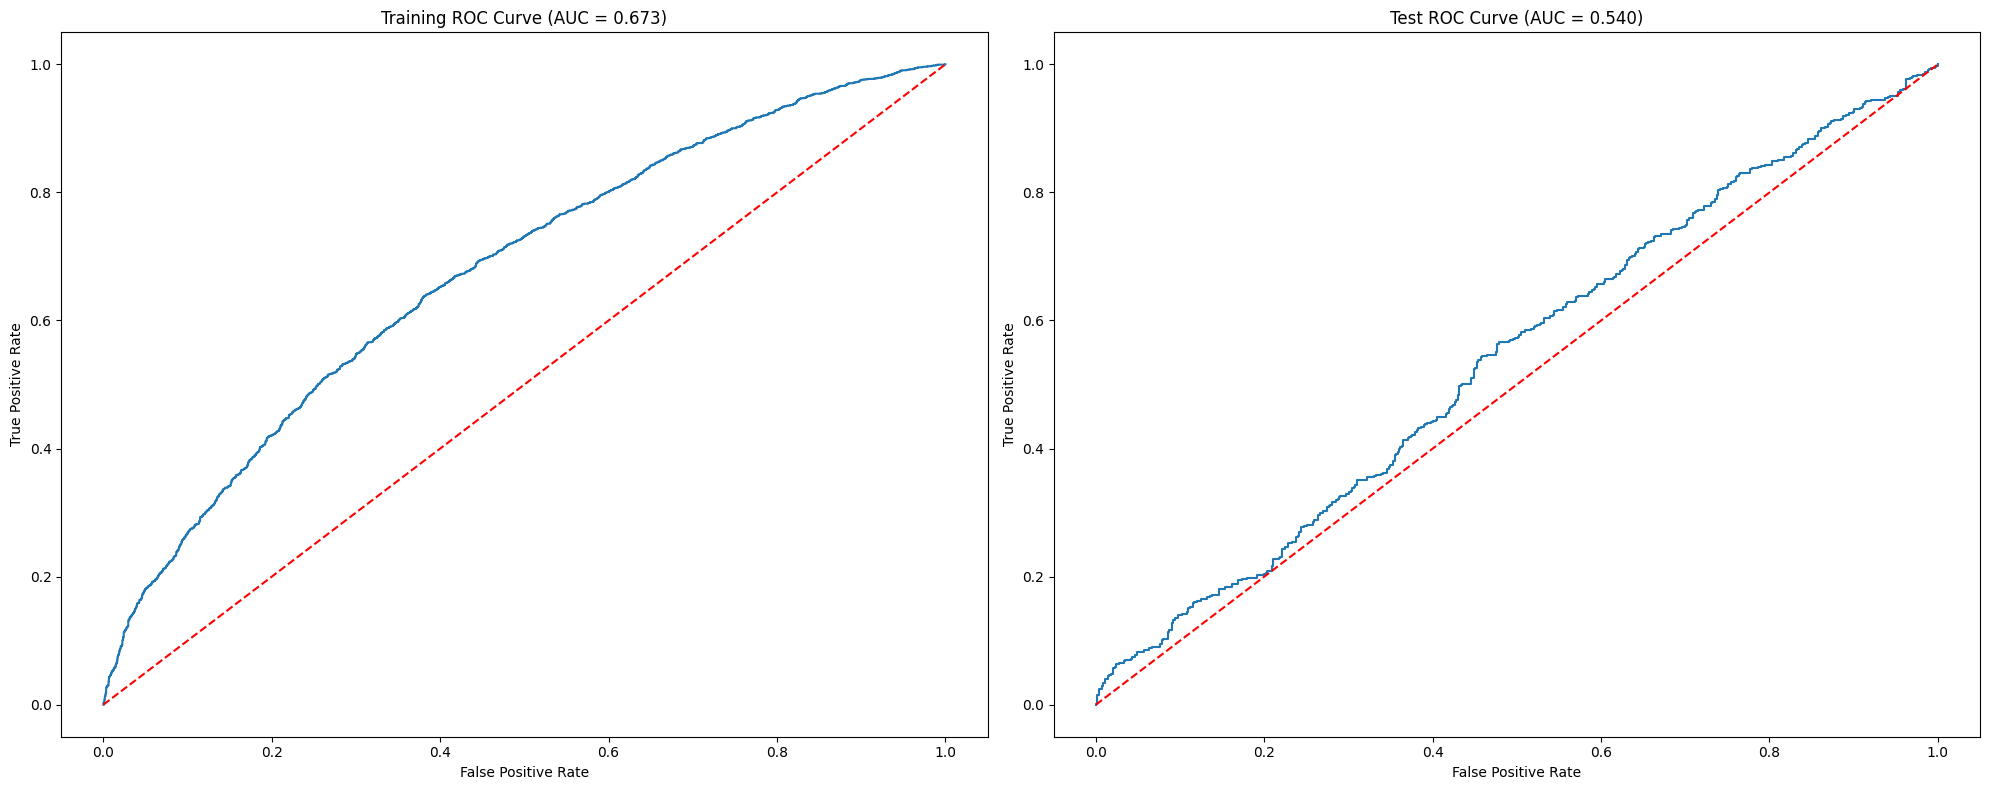

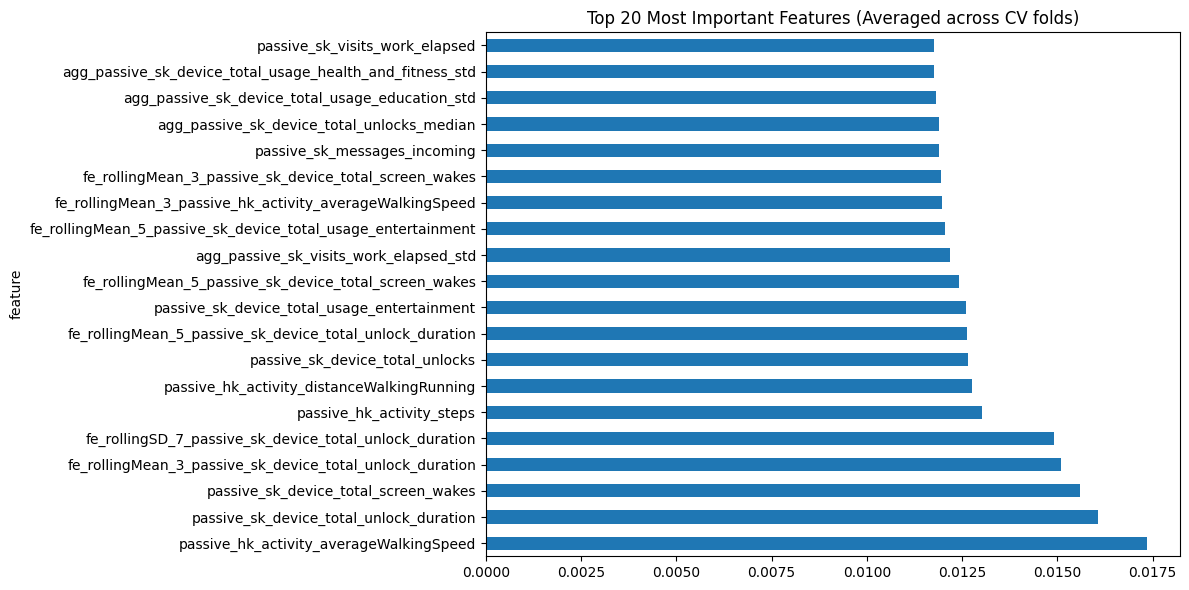

In [320]:
def objective(trial, X, y, cv_folds):
    params = {
        'objective': 'binary:logistic',
        # Reduce model complexity
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True), 
        
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20), 
        'gamma': trial.suggest_float('gamma', 0.5, 3.0),  # Increased gamma range
        
        # More aggressive subsampling
        'subsample': trial.suggest_float('subsample', 0.5, .9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, .9), 
        
        # Stronger L1/L2 regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 10, 100, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 10, 100, log=True),
        
        'random_state': 42,
        'eval_metric': ['auc', 'error'],
        
        'early_stopping_rounds': 30
    }
    
    # Add k-fold cross validation scores
    k_fold_scores = []
    
    for train_idx, val_idx in cv_folds:
        model = xgb.XGBClassifier(**params)
        
        model.fit(
            X.iloc[train_idx], 
            y.iloc[train_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            verbose=False
        )
        
        val_preds = model.predict_proba(X.iloc[val_idx])[:, 1]
        auc_score = roc_auc_score(y.iloc[val_idx], val_preds)
        k_fold_scores.append(auc_score)
    return -np.mean(k_fold_scores)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, X_train, y_train, cv_folds), 
    n_trials=50,
    show_progress_bar=True
)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'random_state': 42,
    'early_stopping_rounds': 30
})

print("\nBest parameters found:", best_params)

# Train final model with best parameters using cross-validation
cv_scores = []
cv_models = []

for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
    fold_model = xgb.XGBClassifier(**best_params)
    fold_model.fit(
        X_train.iloc[train_idx], 
        y_train.iloc[train_idx],
        eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])],
        verbose=False
    )
    cv_models.append(fold_model)
    
    # Calculate fold score
    val_preds = fold_model.predict_proba(X_train.iloc[val_idx])[:, 1]
    fold_score = roc_auc_score(y_train.iloc[val_idx], val_preds)
    cv_scores.append(fold_score)

# Make predictions
y_pred_train_proba = np.mean([model.predict_proba(X_train)[:, 1] for model in cv_models], axis=0)
y_pred_test_proba = np.mean([model.predict_proba(X_test)[:, 1] for model in cv_models], axis=0)

y_pred_train = (y_pred_train_proba > 0.5).astype(int)
y_pred_test = (y_pred_test_proba > 0.5).astype(int)

# Print metrics
print("\nCross-validation ROC-AUC scores:", cv_scores)
print(f"Mean CV ROC-AUC: {-np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
print("\nTraining Set Metrics:")
print(classification_report(y_train, y_pred_train))
print("\nTest Set Metrics:")
print(classification_report(y_test, y_pred_test))

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training ROC
fpr, tpr, _ = roc_curve(y_train, y_pred_train_proba)
train_auc = roc_auc_score(y_train, y_pred_train_proba)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'Training ROC Curve (AUC = {train_auc:.3f})')

# Test ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
test_auc = roc_auc_score(y_test, y_pred_test_proba)
ax2.plot(fpr, tpr)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'Test ROC Curve (AUC = {test_auc:.3f})')

plt.tight_layout()
plt.show()

# Plot feature importance
importance_dfs = []
for model in cv_models:
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    })
    importance_dfs.append(importance_df)

avg_importance = pd.concat(importance_dfs).groupby('feature')['importance'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_importance.head(20).plot(kind='barh')
plt.title('Top 20 Most Important Features (Averaged across CV folds)')
plt.tight_layout()
plt.show()

#### Individual Models

100%|██████████| 104/104 [00:06<00:00, 16.73it/s]



Individual Models Aggregated Results:

Training Set Metrics:
              precision    recall  f1-score   support

           0       0.75      0.49      0.59      2438
           1       0.61      0.84      0.71      2376

    accuracy                           0.66      4814
   macro avg       0.68      0.66      0.65      4814
weighted avg       0.68      0.66      0.65      4814


Test Set Metrics:
              precision    recall  f1-score   support

           0       0.53      0.34      0.41       575
           1       0.50      0.68      0.58       555

    accuracy                           0.51      1130
   macro avg       0.51      0.51      0.50      1130
weighted avg       0.51      0.51      0.49      1130



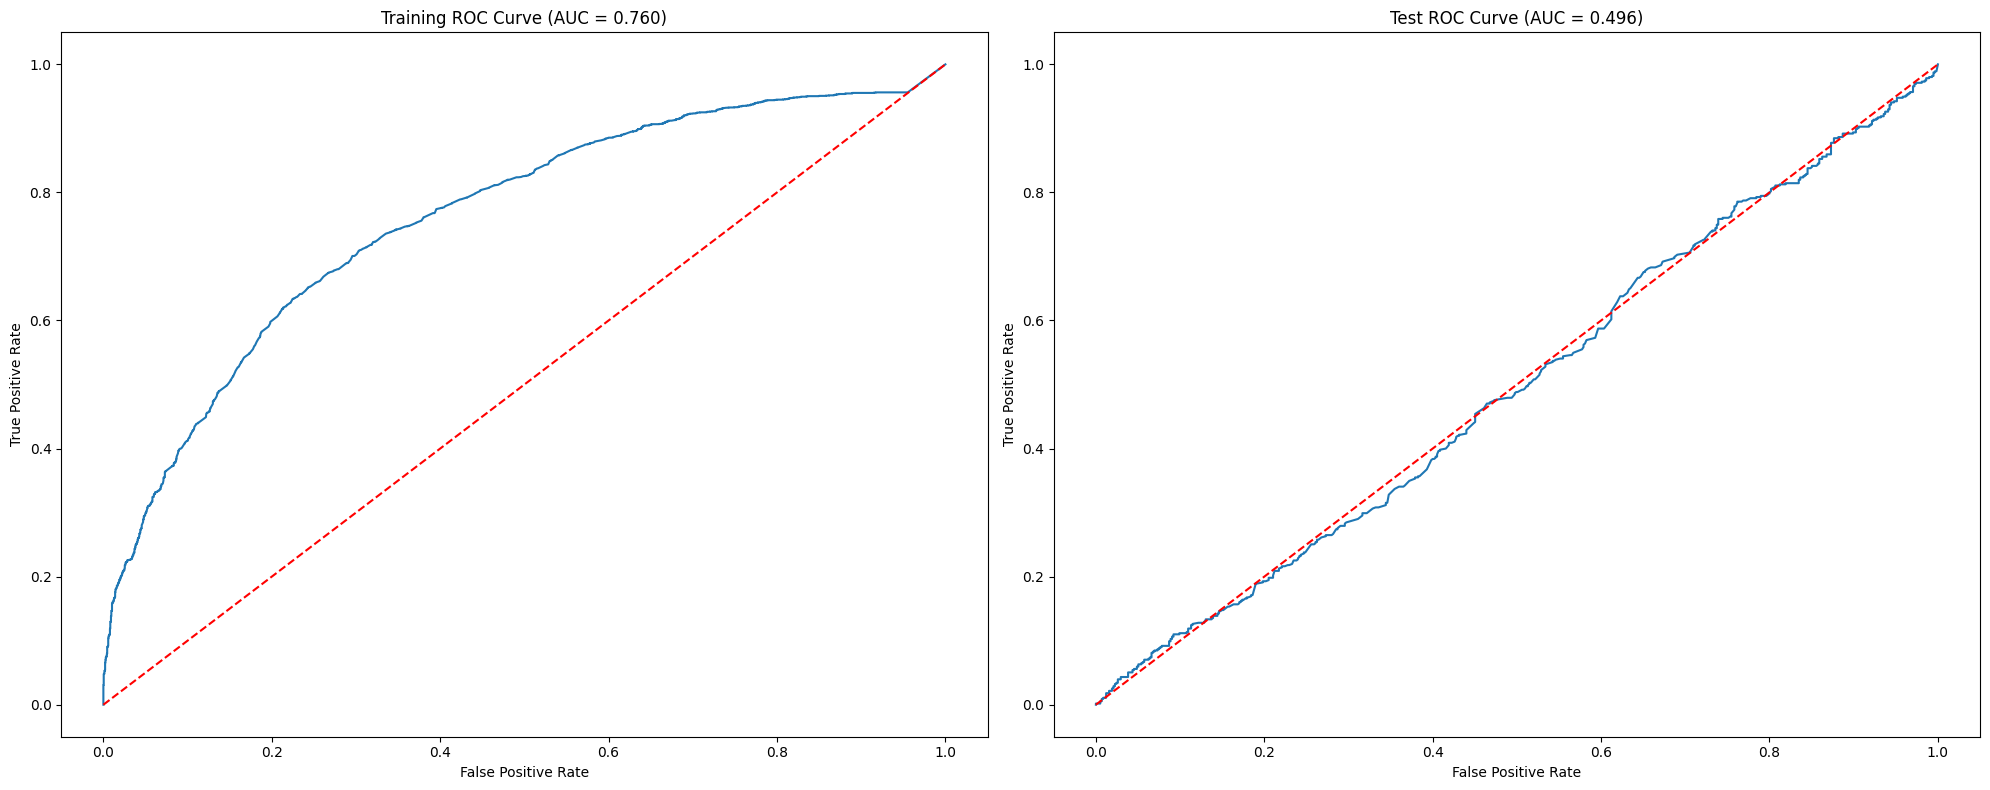

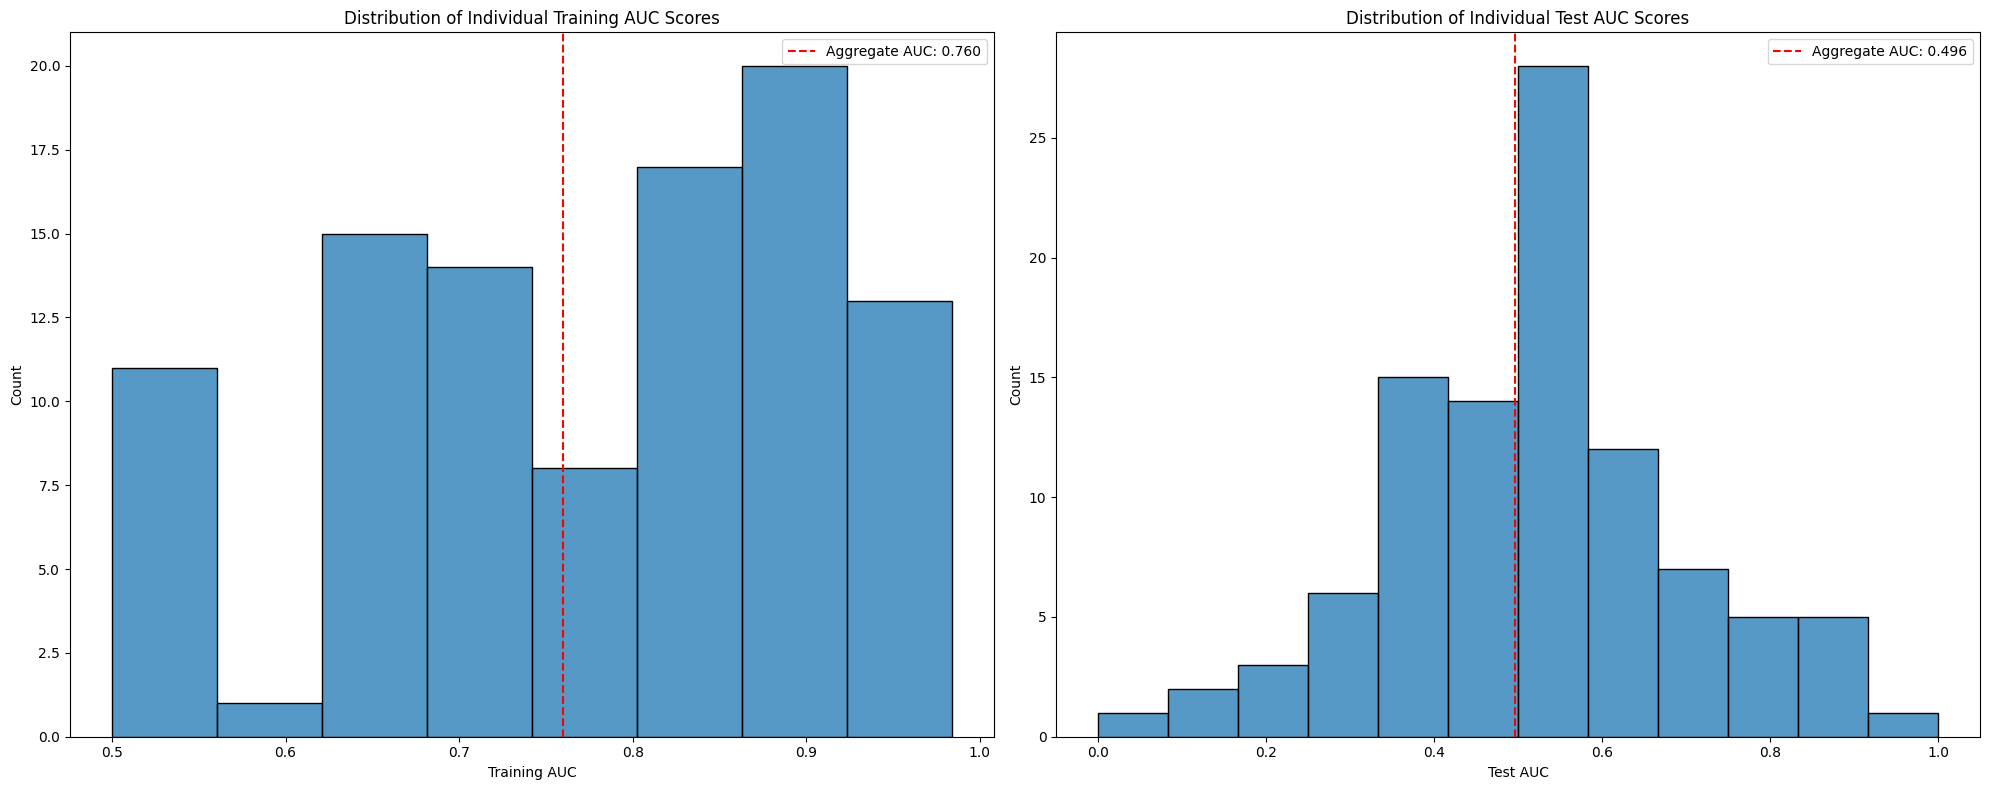


Individual Model Performance Summary:

Training AUC:
count    99.000000
mean      0.771183
std       0.139299
min       0.500000
25%       0.679516
50%       0.802721
75%       0.880108
max       0.983871
Name: train_auc, dtype: float64

Test AUC:
count    99.000000
mean      0.510562
std       0.180441
min       0.000000
25%       0.404545
50%       0.500000
75%       0.612698
max       1.000000
Name: test_auc, dtype: float64


In [354]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold

def train_individual_models(X_train, y_train, X_test, y_test, train_data_clean, test_data_clean, best_params):
    """
    Train individual XGBoost models for each subject with improvements
    """
    model_params = best_params.copy()
    if 'early_stopping_rounds' in model_params:
        del model_params['early_stopping_rounds']
    
    # Initialize arrays
    train_probs = np.zeros(len(y_train))
    test_probs = np.zeros(len(y_test))
    subject_metrics = []
    
    # Add validation split for each subject
    for pid in tqdm(train_data_clean['PID'].unique()):
        train_mask = train_data_clean['PID'] == pid
        test_mask = test_data_clean['PID'] == pid
        
        if not any(test_mask):
            continue
            
        X_train_subj = X_train[train_mask]
        y_train_subj = y_train[train_mask]
        X_test_subj = X_test[test_mask]
        y_test_subj = y_test[test_mask]
        
        # Create validation split for early stopping
        split_idx = int(len(X_train_subj) * 0.8)
        X_train_split = X_train_subj[:split_idx]
        y_train_split = y_train_subj[:split_idx]
        X_val_split = X_train_subj[split_idx:]
        y_val_split = y_train_subj[split_idx:]
        
        # Skip if insufficient data or no variation in target
        if (len(y_train_split) < 20 or 
            len(y_val_split) < 5 or
            len(np.unique(y_train_split)) < 2 or 
            len(np.unique(y_test_subj)) < 2):
            continue
        
        # Calculate class weights with smoothing
        class_counts = np.bincount(y_train_split.astype(int))
        total = len(y_train_split)
        # Add smoothing factor to prevent extreme weights
        smoothing = 1
        class_weights = total / ((class_counts + smoothing) * len(class_counts))
        
        # Create early stopping callback
        early_stopping = xgb.callback.EarlyStopping(
            rounds=20,
            metric_name='logloss',
            save_best=True,
            maximize=False
        )
        
        # Update model parameters for this subject
        subject_params = {
            'objective': 'binary:logistic',
            'max_depth': 4,
            'min_child_weight': 3,
            'learning_rate': 0.01,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'scale_pos_weight': class_weights[1] / class_weights[0],
            'random_state': 42,
            'n_estimators': 1000,
            'enable_categorical': False,
            'callbacks': [early_stopping]
        }
        
        # Train model
        model = xgb.XGBClassifier(**subject_params)
        
        try:
            # Fit model
            model.fit(
                X_train_split, y_train_split,
                eval_set=[(X_val_split, y_val_split)],
                verbose=False
            )
            
            # Make predictions
            train_probs[train_mask] = model.predict_proba(X_train_subj)[:, 1]
            test_probs[test_mask] = model.predict_proba(X_test_subj)[:, 1]
            
            # Calculate metrics
            train_auc = roc_auc_score(y_train_subj, train_probs[train_mask])
            test_auc = roc_auc_score(y_test_subj, test_probs[test_mask])
            
            subject_metrics.append({
                'PID': pid,
                'train_samples': len(y_train_subj),
                'test_samples': len(y_test_subj),
                'train_auc': train_auc,
                'test_auc': test_auc,
                'train_class_dist': np.bincount(y_train_subj.astype(int)),
                'test_class_dist': np.bincount(y_test_subj.astype(int))
            })
            
        except Exception as e:
            print(f"Warning: Error training model for subject {pid}: {str(e)}")
            continue
    
    # Find optimal threshold using cross-validation with multiple metrics
    cv_thresholds = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(train_probs):
        # Test multiple threshold values
        thresholds = np.linspace(0.2, 0.8, 60)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (train_probs[val_idx] > threshold).astype(int)
            f1 = f1_score(y_train[val_idx], y_pred)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                
        cv_thresholds.append(best_threshold)
    
    optimal_threshold = np.median(cv_thresholds)
    
    # Convert probabilities to predictions using optimal threshold
    train_preds = (train_probs > optimal_threshold).astype(int)
    test_preds = (test_probs > optimal_threshold).astype(int)
    
    return {
        'train_preds': train_preds,
        'test_preds': test_preds,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'optimal_threshold': optimal_threshold,
        'subject_metrics': pd.DataFrame(subject_metrics)
    }

# Run individual models
results = train_individual_models(
    X_train, y_train, X_test, y_test, 
    train_data_clean, test_data_clean, 
    best_params
)

# Print metrics
print("\nIndividual Models Aggregated Results:")
print("\nTraining Set Metrics:")
print(classification_report(y_train, results['train_preds']))
print("\nTest Set Metrics:")
print(classification_report(y_test, results['test_preds']))

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training ROC
fpr, tpr, _ = roc_curve(y_train, results['train_probs'])
train_auc = roc_auc_score(y_train, results['train_probs'])
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'Training ROC Curve (AUC = {train_auc:.3f})')

# Test ROC
fpr, tpr, _ = roc_curve(y_test, results['test_probs'])
test_auc = roc_auc_score(y_test, results['test_probs'])
ax2.plot(fpr, tpr)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'Test ROC Curve (AUC = {test_auc:.3f})')

plt.tight_layout()
plt.show()

# Plot distribution of individual subject metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training AUC distribution
sns.histplot(data=results['subject_metrics'], x='train_auc', ax=ax1)
ax1.axvline(train_auc, color='r', linestyle='--', label=f'Aggregate AUC: {train_auc:.3f}')
ax1.set_title('Distribution of Individual Training AUC Scores')
ax1.set_xlabel('Training AUC')
ax1.legend()

# Test AUC distribution
sns.histplot(data=results['subject_metrics'], x='test_auc', ax=ax2)
ax2.axvline(test_auc, color='r', linestyle='--', label=f'Aggregate AUC: {test_auc:.3f}')
ax2.set_title('Distribution of Individual Test AUC Scores')
ax2.set_xlabel('Test AUC')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics of individual model performance
print("\nIndividual Model Performance Summary:")
print("\nTraining AUC:")
print(results['subject_metrics']['train_auc'].describe())
print("\nTest AUC:")
print(results['subject_metrics']['test_auc'].describe())

In [371]:
# Create binary target based on subject's median
train_data_clean['target_above_median'] = (train_data_clean['t_current'] > 
                                          train_data_clean['agg_t_current_median']).astype(int)
test_data_clean['target_above_median'] = (test_data_clean['t_current'] > 
                                         test_data_clean['agg_t_current_median']).astype(int)

# Update target variables
X_train = train_data_clean[features]
y_train = train_data_clean['target_above_median']
X_test = test_data_clean[features]
y_test = test_data_clean['target_above_median']

100%|██████████| 104/104 [00:05<00:00, 17.69it/s]



Summary Statistics:

Mean metrics across subjects:
train_auc              0.905033
test_auc               0.510957
train_class_balance    0.493760
test_class_balance     0.488603
dtype: float64

Standard deviation of metrics across subjects:
train_auc              0.044957
test_auc               0.204594
train_class_balance    0.005710
test_class_balance     0.162220
dtype: float64


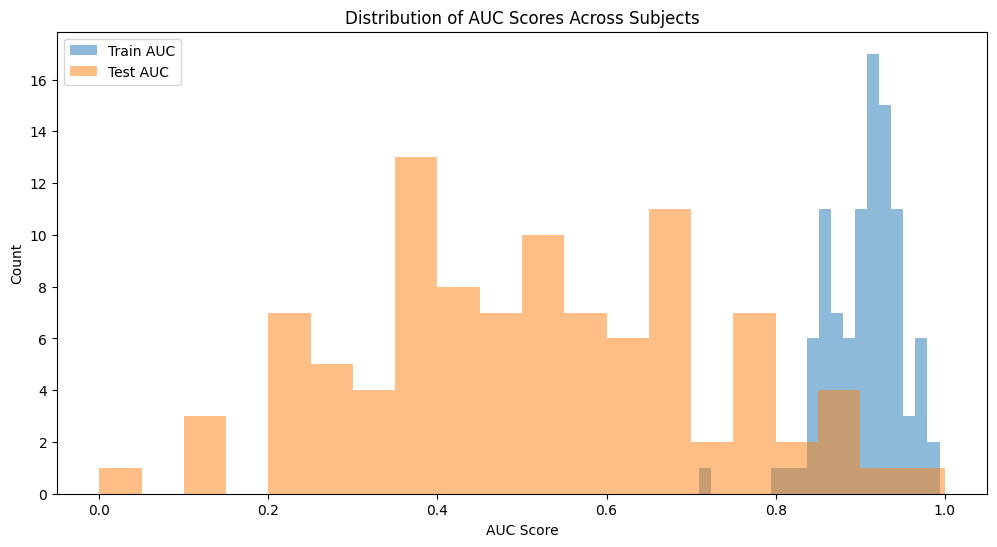

In [382]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance without plotting"""
    # Get predictions
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)
    
    # Get confusion matrices
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_cm = confusion_matrix(y_train, train_preds)
    test_cm = confusion_matrix(y_test, test_preds)
    
    return {
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_tn': train_cm[0,0],
        'train_fp': train_cm[0,1],
        'train_fn': train_cm[1,0],
        'train_tp': train_cm[1,1],
        'test_tn': test_cm[0,0],
        'test_fp': test_cm[0,1],
        'test_fn': test_cm[1,0],
        'test_tp': test_cm[1,1]
    }

# Initialize results dataframe
results = []

# Iterate through all PIDs
for pid in tqdm(train_data_clean['PID'].unique()):
    try:
        # Filter data for current PID
        train_pid_mask = train_data_clean['PID'] == pid
        test_pid_mask = test_data_clean['PID'] == pid
        
        # Create binary target based on subject's median
        train_data_clean.loc[train_pid_mask, 'target_above_median'] = (
            train_data_clean.loc[train_pid_mask, 't_current'] > 
            train_data_clean.loc[train_pid_mask, 'agg_t_current_median']
        ).astype(int)
        
        test_data_clean.loc[test_pid_mask, 'target_above_median'] = (
            test_data_clean.loc[test_pid_mask, 't_current'] > 
            test_data_clean.loc[test_pid_mask, 'agg_t_current_median']
        ).astype(int)
        
        # Get features and targets
        X_train = train_data_clean.loc[train_pid_mask, features].copy()
        X_test = test_data_clean.loc[test_pid_mask, features].copy()
        y_train = train_data_clean.loc[train_pid_mask, 'target_above_median']
        y_test = test_data_clean.loc[test_pid_mask, 'target_above_median']
        
        # Skip if insufficient data
        if len(y_train) < 20 or len(y_test) < 5:
            continue
            
        # Skip if no variation in target
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
            continue
        
        # Handle missing values
        X_train = X_train.ffill()
        X_test = X_test.ffill()
        
        # Drop features with NaN values
        features_with_nans = X_train.columns[X_train.isna().any()].tolist()
        X_train = X_train.drop(columns=features_with_nans)
        X_test = X_test.drop(columns=features_with_nans)
        
        # Train XGBoost
        xgb_model = xgb.XGBClassifier(
            random_state=42,
            max_depth=3,
            min_child_weight=3,
            learning_rate=0.01,
            n_estimators=100,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1,
            reg_lambda=1
        )
        xgb_model.fit(X_train, y_train)
        
        # Evaluate model
        metrics = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)
        
        # Add PID and data counts to metrics
        metrics.update({
            'PID': pid,
            'train_samples': len(y_train),
            'test_samples': len(y_test),
            'train_class_balance': y_train.mean(),
            'test_class_balance': y_test.mean()
        })
        
        results.append(metrics)
        
    except Exception as e:
        print(f"Error processing PID {pid}: {str(e)}")
        continue

# Convert results to dataframe
results_df = pd.DataFrame(results)

# Calculate summary statistics
print("\nSummary Statistics:")
print("\nMean metrics across subjects:")
print(results_df[[
    'train_auc', 'test_auc', 
    'train_class_balance', 'test_class_balance'
]].mean())

print("\nStandard deviation of metrics across subjects:")
print(results_df[[
    'train_auc', 'test_auc', 
    'train_class_balance', 'test_class_balance'
]].std())

# Plot distribution of AUC scores
plt.figure(figsize=(12, 6))
plt.hist(results_df['train_auc'], alpha=0.5, label='Train AUC', bins=20)
plt.hist(results_df['test_auc'], alpha=0.5, label='Test AUC', bins=20)
plt.xlabel('AUC Score')
plt.ylabel('Count')
plt.title('Distribution of AUC Scores Across Subjects')
plt.legend()
plt.show()

# Save results
results_df.to_csv('individual_model_results.csv', index=False)

### Categorical: Increase

#### Create Target

In [397]:
def create_increase_target(df: pd.DataFrame) -> pd.Series:
    """Create target indicating 0.5 SD increase from previous day."""
    targets = pd.Series(index=df.index, dtype=float)
    
    for pid in df['PID'].unique():
        pid_mask = df['PID'] == pid
        pid_data = df[pid_mask].sort_values('day')
        
        # Get subject's SD from their data
        subject_sd = df.loc[pid_mask, 't_current'].std()
        threshold = 0.5 * subject_sd
        
        # Calculate day-over-day change
        pid_data['prev_t_current'] = pid_data['t_current'].shift(1)
        pid_data['prev_day'] = pid_data['day'].shift(1)
        
        # Only mark as increase if we have consecutive days
        increase_mask = (
            (pid_data['t_current'] - pid_data['prev_t_current'] >= threshold) & 
            (pid_data['day'] - pid_data['prev_day'] == 1)
        )
        
        targets.loc[pid_data.index] = increase_mask.astype(float)
    
    return targets

# Create targets for train and test
train_data_clean['target_increase'] = create_increase_target(train_data_clean)
test_data_clean['target_increase'] = create_increase_target(test_data_clean)

# Remove rows where we couldn't calculate the target
train_data_clean = train_data_clean.dropna(subset=['target_increase'])
test_data_clean = test_data_clean.dropna(subset=['target_increase'])

# Update target variables
X_train = train_data_clean[features]
y_train = train_data_clean['target_increase']
X_test = test_data_clean[features]
y_test = test_data_clean['target_increase']

In [400]:
from sklearn.metrics import f1_score, precision_score, recall_score

[I 2025-01-15 13:33:22,551] A new study created in memory with name: no-name-798ae13c-4b3d-490d-a2a8-4ec0b1831fed


Training set class distribution:
target_increase
0.0    0.686539
1.0    0.313461
Name: proportion, dtype: float64

Test set class distribution:
target_increase
0.0    0.717699
1.0    0.282301
Name: proportion, dtype: float64


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-15 13:33:22,938] Trial 0 finished with value: -0.5117182926170785 and parameters: {'n_estimators': 373, 'max_depth': 2, 'learning_rate': 0.05177946463608521, 'min_child_weight': 6, 'subsample': 0.844753662563206, 'colsample_bytree': 0.7075051613539621, 'reg_alpha': 4.484186914298781, 'reg_lambda': 4.569039813152211, 'scale_pos_weight': 7.842699345862026}. Best is trial 0 with value: -0.5117182926170785.
[I 2025-01-15 13:33:25,525] Trial 1 finished with value: -0.5338118518257791 and parameters: {'n_estimators': 206, 'max_depth': 4, 'learning_rate': 0.09847490285243486, 'min_child_weight': 5, 'subsample': 0.7040592693849158, 'colsample_bytree': 0.9974042722702772, 'reg_alpha': 3.178030262027384, 'reg_lambda': 5.075878954009981, 'scale_pos_weight': 9.332502722624046}. Best is trial 1 with value: -0.5338118518257791.
[I 2025-01-15 13:33:29,597] Trial 2 finished with value: -0.550355522731862 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.03068406609822

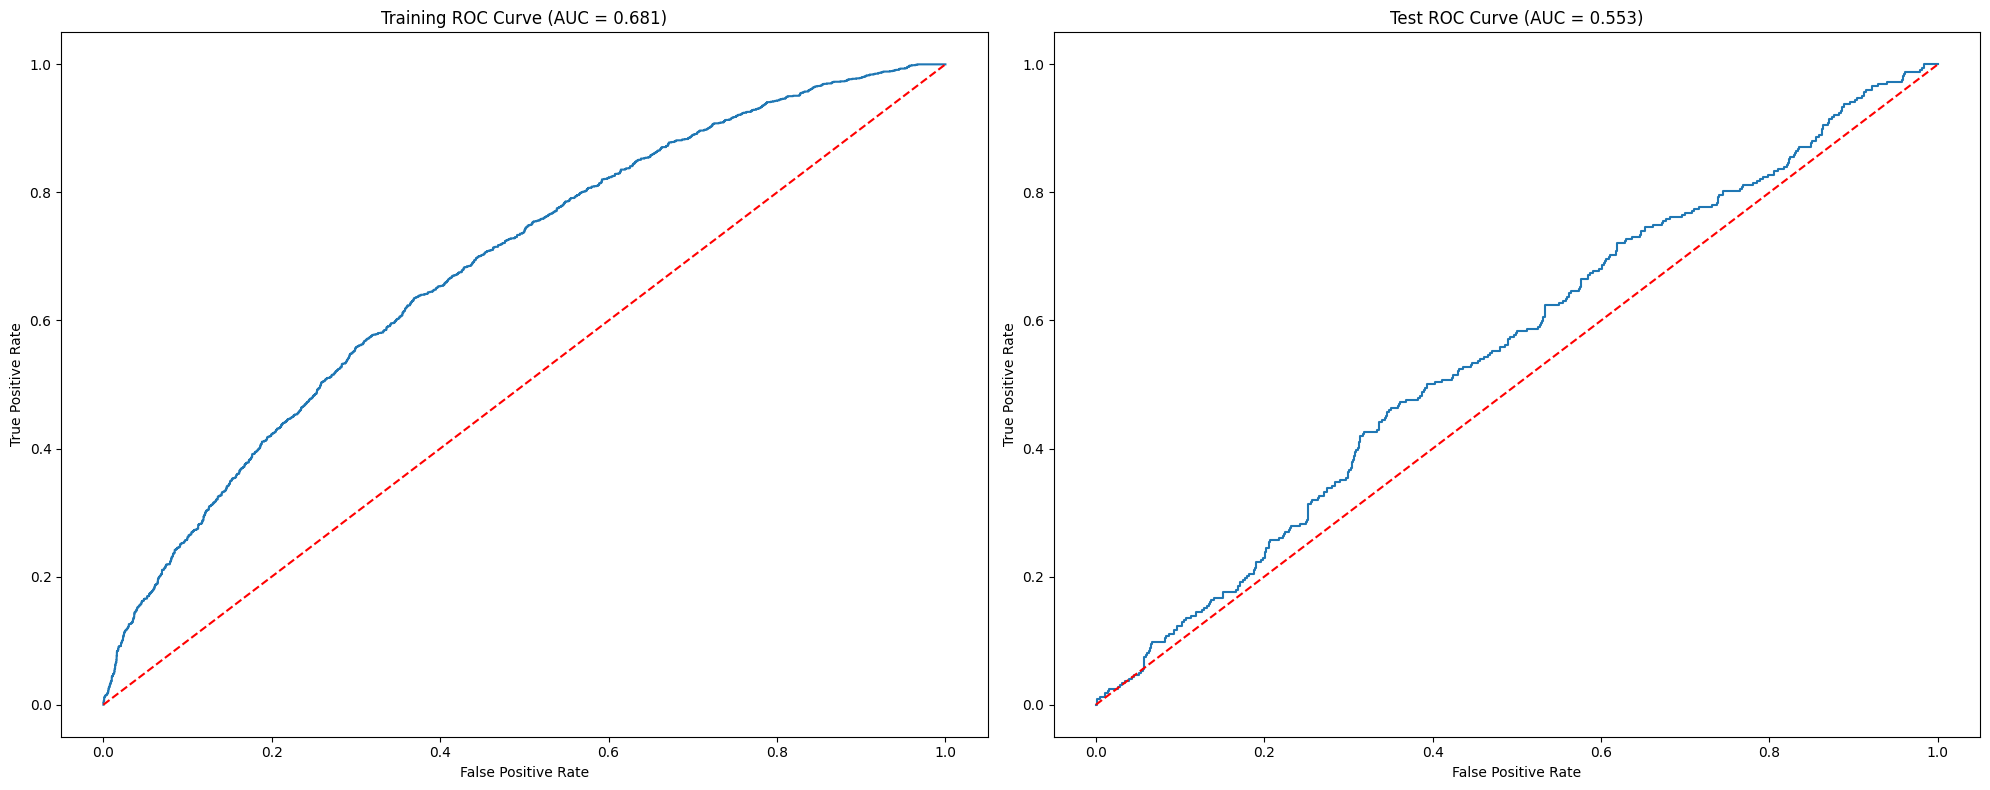

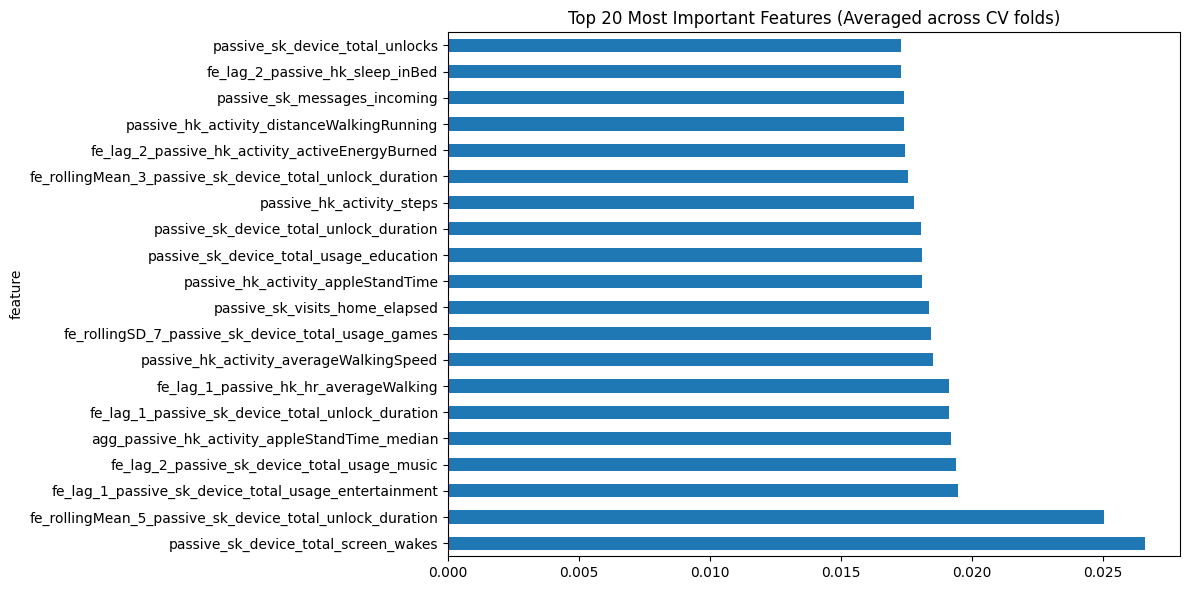

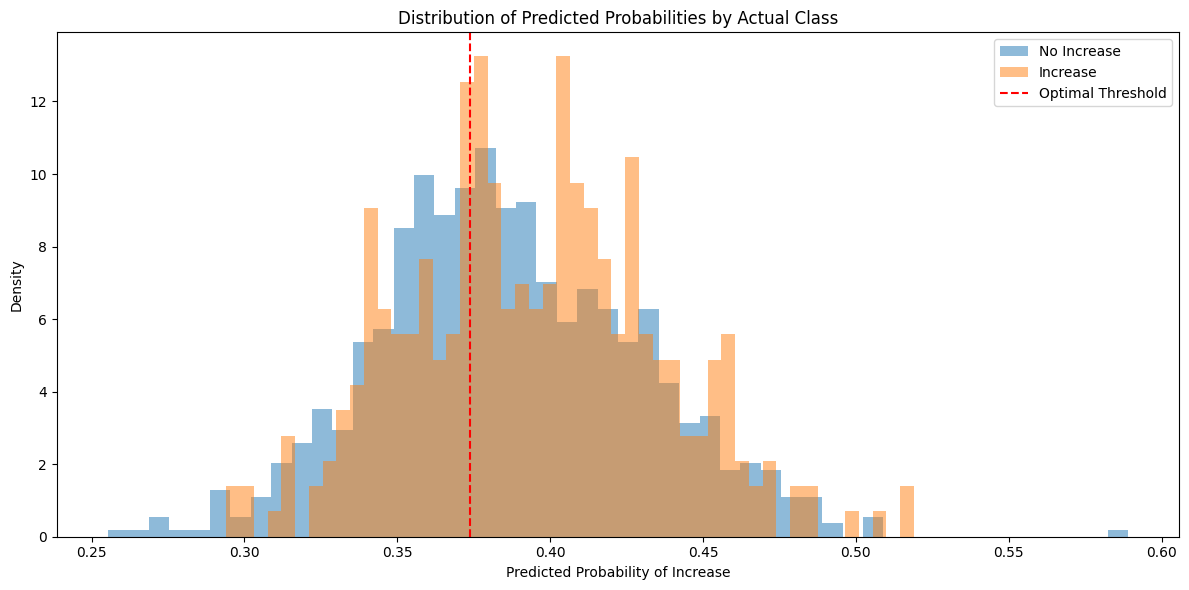

In [405]:
# Print class distribution
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

def objective(trial, X, y, cv_folds):
    params = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 20.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 20.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),  # Added for class imbalance
        'random_state': 42,
        'early_stopping_rounds': 30
    }
    
    fold_scores = []
    
    for train_idx, val_idx in cv_folds:
        model = xgb.XGBClassifier(**params)
        model.fit(
            X.iloc[train_idx], 
            y.iloc[train_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            verbose=False
        )
        
        val_preds = model.predict_proba(X.iloc[val_idx])[:, 1]
        fold_score = roc_auc_score(y.iloc[val_idx], val_preds)
        fold_scores.append(fold_score)
    
    return -np.mean(fold_scores)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, X_train, y_train, cv_folds), 
    n_trials=50,
    show_progress_bar=True
)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'random_state': 42,
    'early_stopping_rounds': 30
})

print("\nBest parameters found:", best_params)

# Train final model with best parameters using cross-validation
cv_scores = []
cv_models = []

for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
    fold_model = xgb.XGBClassifier(**best_params)
    fold_model.fit(
        X_train.iloc[train_idx], 
        y_train.iloc[train_idx],
        eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])],
        verbose=False
    )
    cv_models.append(fold_model)
    
    # Calculate fold score
    val_preds = fold_model.predict_proba(X_train.iloc[val_idx])[:, 1]
    fold_score = roc_auc_score(y_train.iloc[val_idx], val_preds)
    cv_scores.append(fold_score)

# Make predictions
y_pred_train_proba = np.mean([model.predict_proba(X_train)[:, 1] for model in cv_models], axis=0)
y_pred_test_proba = np.mean([model.predict_proba(X_test)[:, 1] for model in cv_models], axis=0)

# Find optimal threshold using training data
thresholds = np.linspace(0, 1, 100)
f1_scores = []
for threshold in thresholds:
    y_pred = (y_pred_train_proba > threshold).astype(int)
    f1 = f1_score(y_train, y_pred)
    f1_scores.append(f1)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# Apply optimal threshold
y_pred_train = (y_pred_train_proba > optimal_threshold).astype(int)
y_pred_test = (y_pred_test_proba > optimal_threshold).astype(int)

# Print metrics
print("\nCross-validation ROC-AUC scores:", cv_scores)
print(f"Mean CV ROC-AUC: {-np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
print("\nTraining Set Metrics:")
print(classification_report(y_train, y_pred_train))
print("\nTest Set Metrics:")
print(classification_report(y_test, y_pred_test))

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Training ROC
fpr, tpr, _ = roc_curve(y_train, y_pred_train_proba)
train_auc = roc_auc_score(y_train, y_pred_train_proba)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'Training ROC Curve (AUC = {train_auc:.3f})')

# Test ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
test_auc = roc_auc_score(y_test, y_pred_test_proba)
ax2.plot(fpr, tpr)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'Test ROC Curve (AUC = {test_auc:.3f})')

plt.tight_layout()
plt.show()

# Plot feature importance
importance_dfs = []
for model in cv_models:
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    })
    importance_dfs.append(importance_df)

avg_importance = pd.concat(importance_dfs).groupby('feature')['importance'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_importance.head(20).plot(kind='barh')
plt.title('Top 20 Most Important Features (Averaged across CV folds)')
plt.tight_layout()
plt.show()

# Additional visualization: Distribution of probabilities
plt.figure(figsize=(12, 6))
plt.hist(y_pred_test_proba[y_test == 0], bins=50, alpha=0.5, label='No Increase', density=True)
plt.hist(y_pred_test_proba[y_test == 1], bins=50, alpha=0.5, label='Increase', density=True)
plt.axvline(optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Predicted Probability of Increase')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by Actual Class')
plt.legend()
plt.tight_layout()
plt.show()


Model Performance vs Random Baseline:
Model AUC: 0.553
Random AUC: 0.495


Running permutation test: 100%|██████████| 10000/10000 [00:08<00:00, 1169.43it/s]



Permutation Test Results:
p-value: 0.0021


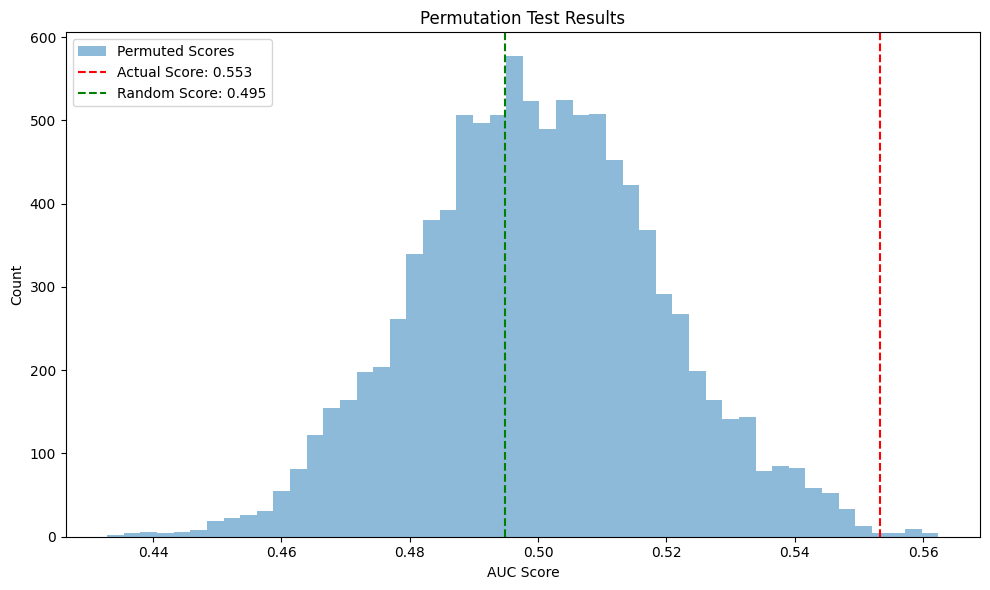

In [406]:
## SIGNIFICANCE TESTING

from scipy import stats
from sklearn.metrics import balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from statsmodels.stats.contingency_tables import mcnemar 

# 1. Compare against stratified random classifier
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
dummy_auc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1])

print("\nModel Performance vs Random Baseline:")
print(f"Model AUC: {test_auc:.3f}")
print(f"Random AUC: {dummy_auc:.3f}")

# 2. Permutation test
n_permutations = 10000
permutation_scores = []

for _ in tqdm(range(n_permutations), desc="Running permutation test"):
    # Shuffle the labels
    y_shuffled = y_test.sample(frac=1, random_state=np.random.randint(0, 10000)).reset_index(drop=True)
    # Calculate AUC with shuffled labels
    perm_auc = roc_auc_score(y_shuffled, y_pred_test_proba)
    permutation_scores.append(perm_auc)

# Calculate p-value
p_value = np.mean(np.array(permutation_scores) >= test_auc)
print(f"\nPermutation Test Results:")
print(f"p-value: {p_value:.4f}")

# # 3. McNemar's test for comparing predictions against majority class
# majority_pred = np.ones(len(y_test)) * stats.mode(y_train)[0]

# table = mcnemar(
#     y_test == y_test.mode()[0],  # Majority class predictions
#     y_test == y_pred_test,       # Model predictions
#     exact=True,
#     correction=True
# )
# print("\nMcNemar's Test Results:")
# print(f"Statistic: {table.statistic:.4f}")
# print(f"p-value: {table.pvalue:.4f}")

# Visualize permutation test results
plt.figure(figsize=(10, 6))
plt.hist(permutation_scores, bins=50, alpha=0.5, label='Permuted Scores')
plt.axvline(test_auc, color='r', linestyle='--', label=f'Actual Score: {test_auc:.3f}')
plt.axvline(dummy_auc, color='g', linestyle='--', label=f'Random Score: {dummy_auc:.3f}')
plt.xlabel('AUC Score')
plt.ylabel('Count')
plt.title('Permutation Test Results')
plt.legend()
plt.tight_layout()
plt.show()

# GPBoost

From [this article](https://towardsdatascience.com/tree-boosted-mixed-effects-models-4df610b624cb)

In [111]:
import gpboost as gpb

## Clean Data

In [126]:
# remove subject `c8b323ca-be8b-4374-ab2c-b4788e4a0e3d` who has NO watch data
train_data = train_data[train_data['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']
test_data = test_data[test_data['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']

In [127]:
# Drop rows with missing values in t_current
train_data_clean = train_data.dropna(subset=['t_current'])
test_data_clean = test_data.dropna(subset=['t_current'])

## Select Features

In [128]:
# Filter features from mlm_gap_df where abs_t_value > 2 and exclude 'css' features
features = [f for f in mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist() 
                       if 'css' not in f]

print(f"Selected {len(features)} features with |t| > 2 (excluding css features):")

Selected 65 features with |t| > 2 (excluding css features):


## Model

Setting up GPBoost model...

Estimated random effects model: 
Covariance parameters (random effects):
              Param.
Error_term  259.6759
Group_1     136.7175


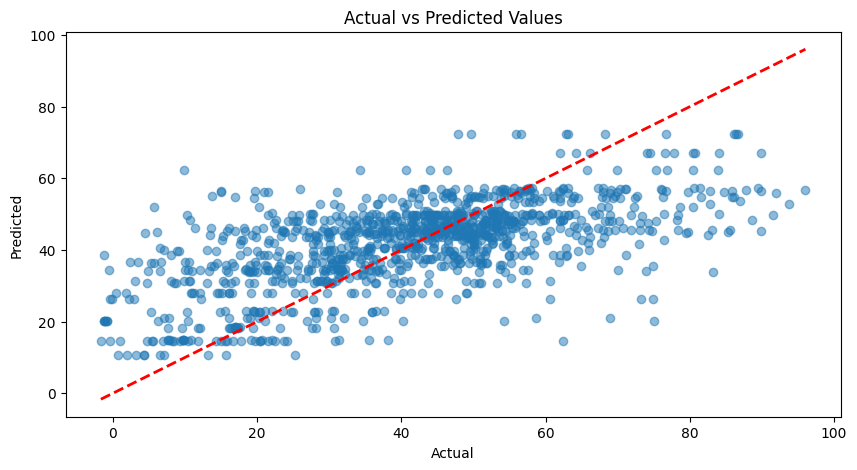


Feature importances: [100, 100, 0, 0, 191, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 100]


[I 2025-01-08 15:39:57,343] A new study created in memory with name: no-name-627f6b59-1cb6-4d6b-9a5e-eb260e5b527b



Optimizing parameters...


[I 2025-01-08 15:40:04,965] Trial 0 finished with value: 267.08013174525905 and parameters: {'learning_rate': 0.013351494520010323, 'min_data_in_leaf': 23, 'max_depth': 2, 'num_leaves': 7, 'lambda_l2': 7.337794540855652, 'max_bin': 76}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:40:23,862] Trial 1 finished with value: 267.5260388685757 and parameters: {'learning_rate': 0.003182077285755199, 'min_data_in_leaf': 3, 'max_depth': 4, 'num_leaves': 24, 'lambda_l2': 20.95972572016474, 'max_bin': 264}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:40:33,057] Trial 2 finished with value: 267.5616701089681 and parameters: {'learning_rate': 0.0035629562476919238, 'min_data_in_leaf': 53, 'max_depth': 2, 'num_leaves': 47, 'lambda_l2': 20.865240118356347, 'max_bin': 202}. Best is trial 0 with value: 267.08013174525905.
[I 2025-01-08 15:42:08,676] Trial 3 finished with value: 267.5578486460375 and parameters: {'learning_rate': 0.0023927654893085163, 'min_data_


Best parameters: {'learning_rate': 0.4502961910373316, 'min_data_in_leaf': 7, 'max_depth': 8, 'num_leaves': 191, 'lambda_l2': 1.3045301643060254, 'max_bin': 205}
Best iteration: 660
Best score: [256.7886727161154]
[GPBoost] [Info] Total Bins 12516
[GPBoost] [Info] Number of data points in the train set: 4814, number of used features: 65
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=41.458249
[GPBoost] [Info] Start training from score 41.458249

Final Model Performance:
Test RMSE: 14.9961
Test MAE: 11.6083


In [129]:
print('Setting up GPBoost model...')

# Prepare data
X_train = train_data_clean[features].values
y_train = train_data_clean['t_current'].values
X_test = test_data_clean[features].values 
y_test = test_data_clean['t_current'].values

# Create PID to numeric index mapping for group data
pid_to_idx = {pid: idx for idx, pid in enumerate(train_data_clean['PID'].unique())}
group_train = train_data_clean['PID'].map(pid_to_idx).values
group_test = test_data_clean['PID'].map(pid_to_idx).values

#--------------------Training----------------
# Define GPModel with random effects grouped by PID
gp_model = gpb.GPModel(group_data=group_train, likelihood="gaussian")

# Train initial model with default parameters
params = {
    'objective': 'regression_l2',
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_data_in_leaf': 5,
    'verbose': 0
}

# Create dataset
train_data = gpb.Dataset(X_train, y_train)

# Train model
bst = gpb.train(params=params,
                train_set=train_data,
                gp_model=gp_model,
                num_boost_round=100)

print("\nEstimated random effects model: ")
gp_model.summary()

#--------------------Prediction----------------
# Make predictions
pred = bst.predict(data=X_test, 
                  group_data_pred=group_test,
                  pred_latent=True)  # Get both fixed and random effects

# Calculate and plot actual vs predicted
plt.figure(figsize=(10, 5))
y_pred = pred['fixed_effect'] + pred['random_effect_mean']
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Print feature importances
print('\nFeature importances:', list(bst.feature_importance()))

#--------------------Parameter Tuning----------------
# Define search space based on GPBoost documentation
search_space = {
    'learning_rate': [0.001, 0.5],
    #'min_data_in_leaf': [1, 100],
    'min_child_weight': [1, 100],
    'max_depth': [2, 8],
    'num_leaves': [2, 256],
    'lambda_l2': [0, 50],
    'max_bin': [63, 512]
}

# Define metric
metric = "mse" # Can also use metric = "test_neg_log_likelihood". For more options, see https://github.com/fabsig/GPBoost/blob/master/docs/Parameters.rst#metric-parameters

gp_model = gpb.GPModel(group_data=group_train, likelihood="gaussian")

# Create validation split using last 20% of data for each PID
train_tune_idx = []
valid_tune_idx = []

# Create folds
folds = expanding_window_cv_nested(train_data_clean)

# Run parameter optimization
print('\nOptimizing parameters...')
opt_params = gpb.tune_pars_TPE_algorithm_optuna(
    X=X_train,
    y=y_train,
    search_space=search_space,
    folds=folds,
    gp_model=gp_model,
    metric=metric,
    tpe_seed=1,
    max_num_boost_round=1000,
    n_trials=100,
    early_stopping_rounds=20
)

print("\nBest parameters:", str(opt_params['best_params']))
print("Best iteration:", str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))

# Train final model with best parameters
final_params = opt_params['best_params']
final_params.update({'n_estimators': opt_params['best_iter']})
final_model = gpb.train(params=final_params,
                       train_set=train_data,
                       gp_model=gp_model)

# Make final predictions
final_pred = final_model.predict(data=X_test, 
                               group_data_pred=group_test,
                               pred_latent=True)
y_pred = final_pred['fixed_effect'] + final_pred['random_effect_mean']

# Calculate final metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"\nFinal Model Performance:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

In [ ]:
print("\nBest parameters:", str(opt_params['best_params']))
print("Best iteration:", str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))

# Train final model with best parameters
final_params = opt_params['best_params']
final_model = gpb.train(params=final_params,
                       train_set=train_data,
                       gp_model=gp_model)

# Make final predictions
final_pred = final_model.predict(data=X_test, 
                               group_data_pred=group_test,
                               pred_latent=True)
y_pred = final_pred['fixed_effect'] + final_pred['random_effect_mean']

# Calculate final metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"\nFinal Model Performance:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


Best parameters: {'learning_rate': 0.40786420567450793, 'min_data_in_leaf': 56, 'max_depth': 7, 'num_leaves': 73, 'lambda_l2': 0.011713989534268138, 'max_bin': 440, 'n_estimators': 1000}
Best iteration: 1000
Best score: [256.50969852823147]
[GPBoost] [Info] Total Bins 28171
[GPBoost] [Info] Number of data points in the train set: 4871, number of used features: 68
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=41.620864
[GPBoost] [Info] Start training from score 41.620864


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/gpboost/engine.py:188: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



Final Model Performance:
Test RMSE: 15.0011
Test MAE: 11.5999


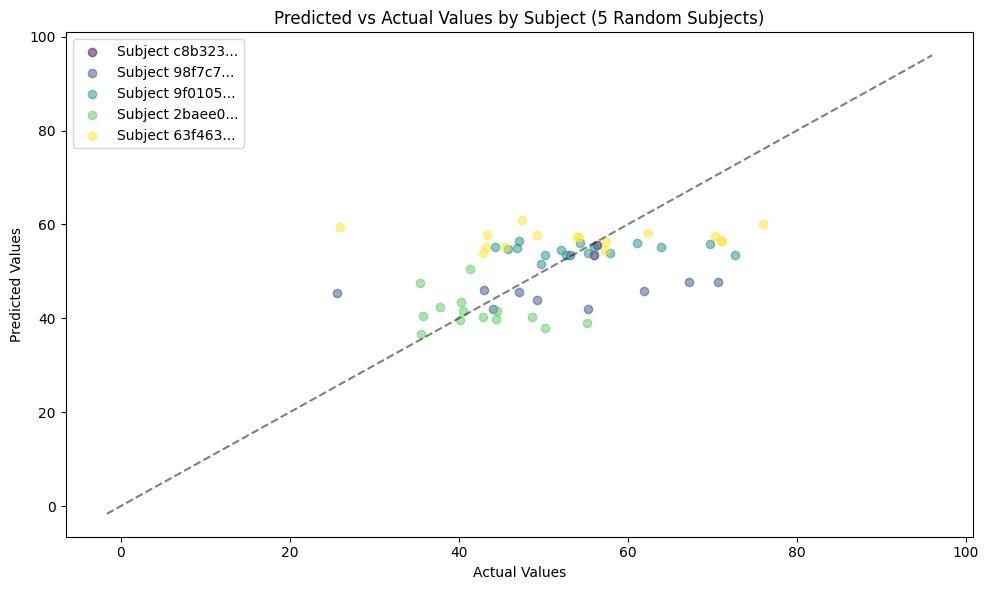

In [ ]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))

# Get unique PIDs and randomly select 5
unique_pids = test_data_clean['PID'].unique()
selected_pids = np.random.choice(unique_pids, size=5, replace=False)

# Create color map for selected PIDs
pid_colors = plt.cm.viridis(np.linspace(0, 1, 5))
pid_color_map = dict(zip(selected_pids, pid_colors))

# Plot points colored by PID for selected PIDs only
for pid in selected_pids:
    mask = test_data_clean['PID'] == pid
    plt.scatter(test_data_clean['t_current'][mask], y_pred[mask], 
               color=pid_color_map[pid], 
               alpha=0.5,
               label=f'Subject {pid[:6]}...')

# Add perfect prediction line
min_val = min(test_data_clean['t_current'].min(), y_pred.min())
max_val = max(test_data_clean['t_current'].max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values by Subject (5 Random Subjects)')
plt.legend()

plt.tight_layout()
plt.show()


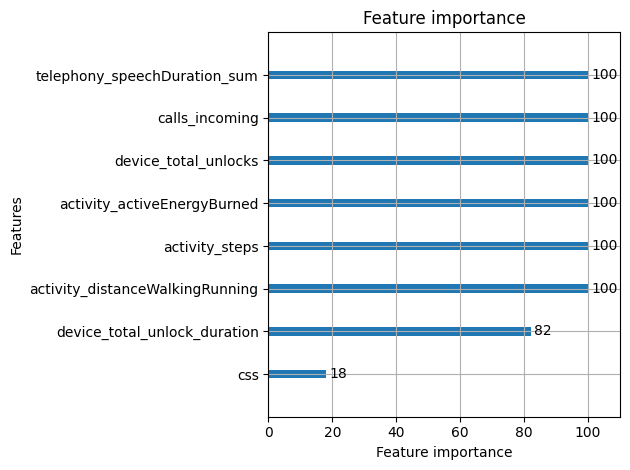

In [ ]:
# Get feature names 
feature_names = features

# Create feature importance plot with actual column names
ax = gpb.plot_importance(bst)

# Get current y-tick labels (which are like "Column_X")
current_labels = ax.get_yticklabels()

# Map the Column_X numbers to actual feature names
new_labels = []
for label in current_labels:
    # Extract the number from "Column_X"
    column_num = int(label.get_text().split('_')[1])
    # Get corresponding feature name
    new_labels.append(feature_names[column_num])

# Set new labels
new_labels = [label.split('passive_', 1)[1][3:] if 'passive_' in label else label for label in new_labels]
ax.set_yticklabels(new_labels)

plt.tight_layout()
plt.show()